# インポート

In [2]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import pandas_profiling as pdp
import numpy as np

import lightgbm as lgb

#回帰の可視化
#関数の処理で必要なライブラリ
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer

from sklearn.ensemble import (
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)

import shap
# import xgboost

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

import warnings
warnings.filterwarnings('ignore')

# 関数

In [3]:
def count_amenity(x):
    return len(str(x).split('{')[1].split('}')[0].split(','))

In [4]:
def preprocessing(ori_df):
    df = ori_df.copy()
    s = df["amenities"].copy()
    df['amenities_count'] = s.map(count_amenity)
    
    df['description_word_count'] = df['description'].map(lambda x: len(x))
    
    df['host_response_rate'] =\
    df['host_response_rate'].str.split("%", expand=True)[0]
    df['host_response_rate'] = df['host_response_rate'].fillna(0).astype('int')
    
    #最初のレビュー日
    df['first_review'] = pd.to_datetime(df['first_review'])
    df["first_review_Year"] = df["first_review"].apply(lambda x:x.year)
    df["first_review_Month"] = df["first_review"].apply(lambda x:x.month)
    df["first_review_Day"] = df["first_review"].apply(lambda x:x.day)
    df["kijun"] = "2008-11-17"
    df["kijun"] = pd.to_datetime(df["kijun"])
    df["BusinessOld"] = (df["first_review"] - df["kijun"]).apply(lambda x: x.days)
    
    #登録した日
    df['host_since'] = pd.to_datetime(df['host_since'])
    df["host_since_Year"] = df["host_since"].apply(lambda x:x.year)
    df["host_since_Month"] = df["host_since"].apply(lambda x:x.month)
    df["host_since_Day"] = df["host_since"].apply(lambda x:x.day)
    df["kijun2"] = "2008-3-3"
    df["kijun2"] = pd.to_datetime(df["kijun2"])
    df["BusinessOld2"] = (df["host_since"] - df["kijun2"]).apply(lambda x: x.days)
    df["first_reviewOld"] = (df["first_review"] - df["host_since"]).apply(lambda x: x.days)
    
    #最後のレビュー日
    df['last_review'] = pd.to_datetime(df['last_review'])
    df["last_review_Year"] = df["last_review"].apply(lambda x:x.year)
    df["last_review_Month"] = df["last_review"].apply(lambda x:x.month)
    df["last_review_Day"] = df["last_review"].apply(lambda x:x.day)
    df["kijun3"] = "2021-12-30"
    df["kijun3"] = pd.to_datetime(df["kijun3"])
    df["BusinessOld3"] = (df["last_review"] - df["kijun"]).apply(lambda x: x.days)
    df["BusinessUpdate"] = (df["kijun3"] - df["last_review"]).apply(lambda x: x.days)
    df["BusinessPeriod"] = (df["last_review"] - df["first_review"]).apply(lambda x: x.days)
    
    df['thumbnail_url'][df['thumbnail_url'].notnull()] = 1
    
    zipcode = df['zipcode'].str.replace('Near', '').str.replace('m', '').replace(' ', np.nan)\
                                                                                 .str.split("\r", expand=True)[0].str.split("-", expand=True)[0].str.split(".", expand=True)[0]
    df['zipcode_int'] = zipcode
    df['zipcode_int'] = df['zipcode_int'].fillna(0).astype(int)

    
    #不必要なcolumnを落とす
    df.drop(['amenities'], axis=1, inplace=True)
    df.drop(['description'], axis=1, inplace=True)
    df = df.drop('first_review', axis=1)
    df = df.drop('kijun', axis=1)
    df = df.drop('host_since', axis=1)
    df = df.drop('kijun2', axis=1)
    df = df.drop('last_review', axis=1)
    df = df.drop('kijun3', axis=1)
    df = df.drop('zipcode', axis=1)
    
    #特徴量にできてない
    #df = df.drop('id', axis=1)
    df = df.drop('name', axis=1)
    
    #型変更
    num_col = [col for col in df.select_dtypes(exclude=object)]
    df[num_col] = df[num_col].astype('float')
    
    return df

In [5]:
#カテゴリカル変数化
def process_categorical(df, target_columns):
    df2 = df.copy()
    for column in target_columns:
        df2[column] = LabelEncoder().fit_transform(df2[column].fillna('Na'))

    #ターゲットカラム以外にカテゴリ変数があれば, ダミー変数にする
    df2 = pd.get_dummies(df2)

    for column in tqdm(target_columns):
        df2[column] = df2[column].astype('category')

    return df2

In [6]:
#予測値と正解値を描写する関数
def True_Pred_map(pred_df):
    RMSE = np.sqrt(mean_squared_error(pred_df['true'], pred_df['pred']))
    R2 = r2_score(pred_df['true'], pred_df['pred'])
    plt.figure(figsize=(8,8))
    ax = plt.subplot(111)
    ax.scatter('true', 'pred', data=pred_df)
    ax.set_xlabel('True Value', fontsize=15)
    ax.set_ylabel('Pred Value', fontsize=15)
    ax.set_xlim(pred_df.min().min()-0.05 , pred_df.max().max()+0.05)
    ax.set_ylim(pred_df.min().min()-0.05 , pred_df.max().max()+0.05)
    x = np.linspace(pred_df.min().min()-0.05, pred_df.max().max()+0.05, 2)
    y = x
    ax.plot(x,y,'r-')
    plt.text(0.1, 0.9, 'RMSE = {}'.format(str(round(RMSE, 5))), transform=ax.transAxes, fontsize=15)
    plt.text(0.1, 0.8, 'R^2 = {}'.format(str(round(R2, 5))), transform=ax.transAxes, fontsize=15)

# データの読み込み

In [3]:
csv_to_df_train = pd.read_csv('train.csv')
csv_to_df_test = pd.read_csv('test.csv')
csv_to_df_sample = pd.read_csv('sample_submit.csv')

In [4]:
train = pd.read_csv('train.csv')
test_x = pd.read_csv('test.csv')

del train['id']
del test_x['id']

print('len(train)=', len(train))
print('len(test_x)', len(test_x))
print(len(test_x)/len(train))

len(train)= 55583
len(test_x) 18528
0.3333393303707968


In [5]:
train.head()

accommodates                                          amenities  bathrooms  \
0             6  {TV,"Wireless Internet",Kitchen,"Free parking ...        2.0   
1             2  {TV,"Cable TV",Internet,"Wireless Internet","A...        1.0   
2             2  {TV,Internet,"Wireless Internet",Kitchen,"Indo...        2.0   
3             2  {TV,"Cable TV",Internet,"Wireless Internet","A...        1.0   
4             2  {TV,Internet,"Wireless Internet","Air conditio...        1.0   

   bed_type  bedrooms  beds cancellation_policy city cleaning_fee  \
0  Real Bed       1.0   4.0            flexible   LA            t   
1  Real Bed       1.0   1.0              strict   DC            t   
2  Real Bed       1.0   1.0              strict  NYC            t   
3  Real Bed       1.0   1.0              strict   SF            t   
4  Real Bed       1.0   1.0              strict  NYC            t   

                                         description first_review  \
0  My place is meant for family and a few friends...   2016-07-27   
1  This is a new listing for a lovely guest bedro...   2016-09-12   
2  We're looking forward to your stay at our apt....   2016-06-15   
3  BEST CITY VIEWS - - ROOF DECK W/ BBQ & WiFi - ...   2014-03-15   
4  Charming Apartment on the upper west side of M...   2015-08-05   

  host_has_profile_pic host_identity_verified host_response_rate  host_since  \
0                    t                      f                NaN  2016-07-13   
1                    t                      t               100%  2015-12-30   
2                    t                      f               100%  2016-05-21   
3                    t                      t               100%  2012-06-19   
4                    t                      t               100%  2015-03-25   

  instant_bookable last_review   latitude   longitude  \
0                f  2016-07-27  33.788931 -118.154761   
1                f  2017-03-31  38.934810  -76.978190   
2                t  2017-08-13  40.695118  -73.926240   
3                t  2017-09-03  37.796728 -122.411906   
4                f  2017-09-10  40.785050  -73.974691   

                                                name    neighbourhood  \
0                                      The Penthouse              NaN   
1                         Guest Bedroom in Brookland        Brookland   
2  Clean Modern Room in Lux Apt 1 Block From J Train         Bushwick   
3               BEST views + reviews! 5/5 stars*****         Nob Hill   
4                 Charming 1-bedroom - UWS Manhattan  Upper West Side   

   number_of_reviews property_type  review_scores_rating        room_type  \
0                  1     Apartment                  60.0     Private room   
1                  9         House                 100.0     Private room   
2                 27     Apartment                  83.0     Private room   
3                 38     Apartment                  95.0     Private room   
4                  5     Apartment                 100.0  Entire home/apt   

                                       thumbnail_url zipcode      y  
0                                                NaN   90804  138.0  
1  https://a0.muscache.com/im/pictures/e4d8b51f-6...   20018   42.0  
2  https://a0.muscache.com/im/pictures/5ffecc9b-d...     NaN   65.0  
3                                                NaN   94133  166.0  
4  https://a0.muscache.com/im/pictures/92879730/5...   10024  165.0

In [10]:
test_x.head()

accommodates                                          amenities  bathrooms  \
0             6  {TV,"Cable TV","Wireless Internet","Air condit...        2.0   
1             3  {TV,"Cable TV",Internet,"Wireless Internet","A...        1.0   
2             2  {TV,"Wireless Internet","Air conditioning",Kit...        1.0   
3             4  {TV,"Cable TV",Internet,"Wireless Internet","A...        1.0   
4             3  {TV,Internet,"Wireless Internet","Air conditio...        1.5   

   bed_type  bedrooms  beds cancellation_policy    city cleaning_fee  \
0  Real Bed       2.0   2.0              strict  Boston            t   
1  Real Bed       1.0   1.0            moderate      LA            t   
2  Real Bed       0.0   1.0            flexible     NYC            f   
3  Real Bed       1.0   2.0              strict     NYC            f   
4  Real Bed       1.0   2.0              strict      LA            t   

                                         description first_review  \
0  Feel free to book INSTANTLY. You can check-in ...   2017-01-09   
1  The guest house is close to: Equinox West Holl...   2016-08-17   
2  Private room in a three bedroom apartment in N...          NaN   
3  The apartment is located in historic Bed Stuy ...          NaN   
4  Our cozy, pet friendly one bedroom apartment/l...   2015-08-01   

  host_has_profile_pic host_identity_verified host_response_rate  host_since  \
0                    t                      f               100%  2016-08-23   
1                    t                      t               100%  2014-09-03   
2                    t                      t               100%  2012-10-17   
3                    t                      t                NaN  2013-01-23   
4                    t                      t               100%  2014-12-28   

  instant_bookable last_review   latitude   longitude  \
0                t  2017-09-25  42.359278  -71.069962   
1                f  2017-05-02  34.084747 -118.367355   
2                f         NaN  40.720541  -73.959192   
3                f         NaN  40.681117  -73.944091   
4                f  2016-09-11  34.150995 -118.409359   

                                                name       neighbourhood  \
0             Gorgeous 2BR/2BA Duplex in Beacon Hill         Beacon Hill   
1        Luxury 1 Bedroom West Hollywood City Center      West Hollywood   
2  Bedroom with Patio in Prime Williamsburg Locat...        Williamsburg   
3                         Cozy apartment in Brooklyn  Bedford-Stuyvesant   
4                 Cozy, sunny, pet friendly loft/apt                 NaN   

   number_of_reviews property_type  review_scores_rating        room_type  \
0                 58         House                  90.0  Entire home/apt   
1                  4    Guesthouse                 100.0  Entire home/apt   
2                  0     Apartment                   NaN     Private room   
3                  0     Apartment                   NaN  Entire home/apt   
4                  6          Loft                  92.0  Entire home/apt   

                                       thumbnail_url  zipcode  
0  https://a0.muscache.com/im/pictures/7e4808b4-5...    02114  
1  https://a0.muscache.com/im/pictures/5392fbd6-6...    90046  
2  https://a0.muscache.com/im/pictures/544d3b89-d...  11249.0  
3  https://a0.muscache.com/im/pictures/26baf7ba-0...    11216  
4  https://a0.muscache.com/im/pictures/86107545/9...    91604

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55583 entries, 0 to 55582
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   accommodates            55583 non-null  int64  
 1   amenities               55583 non-null  object 
 2   bathrooms               55436 non-null  float64
 3   bed_type                55583 non-null  object 
 4   bedrooms                55512 non-null  float64
 5   beds                    55487 non-null  float64
 6   cancellation_policy     55583 non-null  object 
 7   city                    55583 non-null  object 
 8   cleaning_fee            55583 non-null  object 
 9   description             55583 non-null  object 
 10  first_review            43675 non-null  object 
 11  host_has_profile_pic    55435 non-null  object 
 12  host_identity_verified  55435 non-null  object 
 13  host_response_rate      41879 non-null  object 
 14  host_since              55435 non-null

# プロファイリング

In [126]:
pdp.ProfileReport(train)

Summarize dataset:   0%|          | 0/41 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# EDA

## 説明変数

|カラム|ヘッダ名称|データ型|説明|
|-|-|-|-|
|0|	id|	int| インデックスとして使用|
|1|	accommodates|	int|	収容可能人数|
|2|	amenities|	char|	アメニティ|
|3|	bathrooms|	float|	風呂数|
|4|	bed_type|	char|	ベッドの種類|
|5|	bedrooms|	float|	ベッドルーム数|
|6|	beds|	float|	ベッド数|
|7|	cancellation_policy|	char|	キャンセルポリシー|
|8|	city|	char|	都市|
|9|	cleaning_fee|	int|	クリーニング料金を含むか|
|10|	description|	char|	説明|
|11|	first_review|	char|	最初のレビュー日|
|12|	host_has_profile_pic|	int|	ホストの写真があるかどうか|
|13|	host_identity_verified|	int|	ホストの身元確認が取れているか|
|14|	host_response_rate|	char|	ホストの返信率|
|15|	host_since|	char|	ホストの登録日|
|16|	instant_bookable|	char|	即時予約可能か|
|17|	last_review	|char|	最後のレビュー日|
|18|	latitude|	float|	緯度|
|19|longitude|	float|	経度|
|20|	name|	char|	物件名|
|21|	neighbourhood|	char|	近隣情報|
|22|	number_of_reviews|	int|	レビュー数|
|23|	property_type|	char|	物件の種類|
|24|	review_scores_rating|	float|	レビュースコア|
|25|	room_type|	char|	部屋の種類|
|26|	thumbnail_url|	char|	サムネイル画像リンク|
|27|	zipcode|	int|	郵便番号|
|28|    y| float|	宿泊価格|

In [6]:
df_train_addEDA = train.copy()
df_train_addEDA.head()

accommodates                                          amenities  bathrooms  \
0             6  {TV,"Wireless Internet",Kitchen,"Free parking ...        2.0   
1             2  {TV,"Cable TV",Internet,"Wireless Internet","A...        1.0   
2             2  {TV,Internet,"Wireless Internet",Kitchen,"Indo...        2.0   
3             2  {TV,"Cable TV",Internet,"Wireless Internet","A...        1.0   
4             2  {TV,Internet,"Wireless Internet","Air conditio...        1.0   

   bed_type  bedrooms  beds cancellation_policy city cleaning_fee  \
0  Real Bed       1.0   4.0            flexible   LA            t   
1  Real Bed       1.0   1.0              strict   DC            t   
2  Real Bed       1.0   1.0              strict  NYC            t   
3  Real Bed       1.0   1.0              strict   SF            t   
4  Real Bed       1.0   1.0              strict  NYC            t   

                                         description first_review  \
0  My place is meant for family and a few friends...   2016-07-27   
1  This is a new listing for a lovely guest bedro...   2016-09-12   
2  We're looking forward to your stay at our apt....   2016-06-15   
3  BEST CITY VIEWS - - ROOF DECK W/ BBQ & WiFi - ...   2014-03-15   
4  Charming Apartment on the upper west side of M...   2015-08-05   

  host_has_profile_pic host_identity_verified host_response_rate  host_since  \
0                    t                      f                NaN  2016-07-13   
1                    t                      t               100%  2015-12-30   
2                    t                      f               100%  2016-05-21   
3                    t                      t               100%  2012-06-19   
4                    t                      t               100%  2015-03-25   

  instant_bookable last_review   latitude   longitude  \
0                f  2016-07-27  33.788931 -118.154761   
1                f  2017-03-31  38.934810  -76.978190   
2                t  2017-08-13  40.695118  -73.926240   
3                t  2017-09-03  37.796728 -122.411906   
4                f  2017-09-10  40.785050  -73.974691   

                                                name    neighbourhood  \
0                                      The Penthouse              NaN   
1                         Guest Bedroom in Brookland        Brookland   
2  Clean Modern Room in Lux Apt 1 Block From J Train         Bushwick   
3               BEST views + reviews! 5/5 stars*****         Nob Hill   
4                 Charming 1-bedroom - UWS Manhattan  Upper West Side   

   number_of_reviews property_type  review_scores_rating        room_type  \
0                  1     Apartment                  60.0     Private room   
1                  9         House                 100.0     Private room   
2                 27     Apartment                  83.0     Private room   
3                 38     Apartment                  95.0     Private room   
4                  5     Apartment                 100.0  Entire home/apt   

                                       thumbnail_url zipcode      y  
0                                                NaN   90804  138.0  
1  https://a0.muscache.com/im/pictures/e4d8b51f-6...   20018   42.0  
2  https://a0.muscache.com/im/pictures/5ffecc9b-d...     NaN   65.0  
3                                                NaN   94133  166.0  
4  https://a0.muscache.com/im/pictures/92879730/5...   10024  165.0

## 欠損値のカウント

<AxesSubplot:>

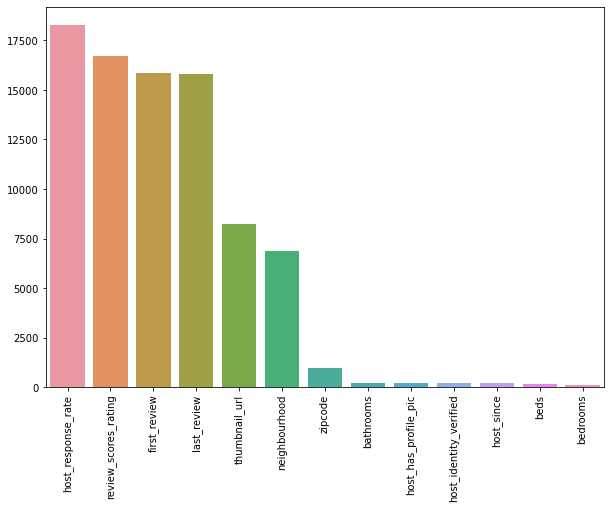

In [8]:
#学習データを目的変数とそれ以外に分ける
train_x = train.drop("y",axis=1)
train_y = train["y"]
#学習データとテストデータを統合
all_data = pd.concat([train_x,test_x],axis=0,sort=True)

#データの欠損値を確認する
all_data_na = all_data.isnull().sum()[all_data.isnull().sum()>0].sort_values(ascending=False)

#欠損値の数をグラフ化
plt.figure(figsize=(10,7))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)

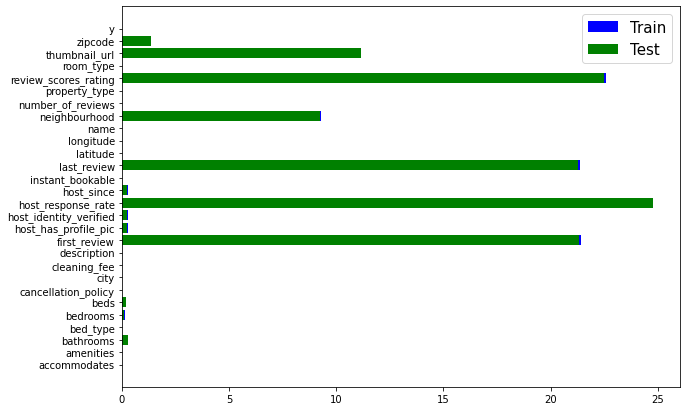

In [15]:
#欠損率
#欠損値をカウントしたDataFrameの作成
missing_train = pd.DataFrame(train.isnull().sum() / len(train) * 100)
missing_train = missing_train.rename(columns={0:'missing_value_rate'})
missing_test = pd.DataFrame(test_x.isnull().sum() / len(test_x) * 100)
missing_test = missing_test.rename(columns={0:'missing_value_rate'})

fig = plt.figure(figsize=(10,7))
plt.barh(missing_train.index, missing_train.missing_value_rate, color='blue')
plt.barh(missing_test.index, missing_test.missing_value_rate, color='green')
plt.legend(['Train', 'Test'], fontsize=15)

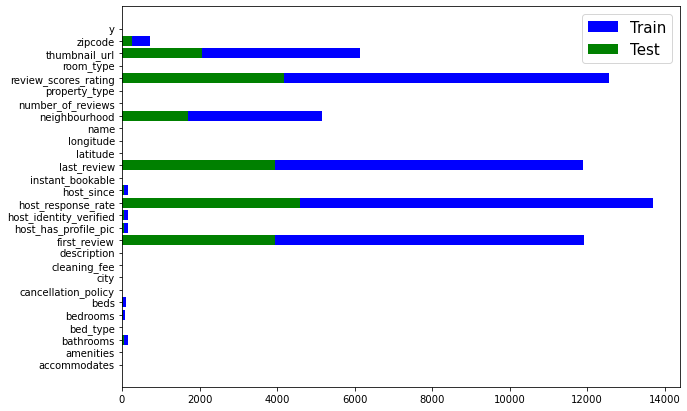

In [16]:
#欠損数
#欠損値をカウントしたDataFrameの作成
missing_train = pd.DataFrame(train.isnull().sum())
missing_train = missing_train.rename(columns={0:'missing_value_counts'})
missing_test = pd.DataFrame(test_x.isnull().sum())
missing_test = missing_test.rename(columns={0:'missing_value_counts'})

fig = plt.figure(figsize=(10,7))
plt.barh(missing_train.index, missing_train.missing_value_counts, color='blue')
plt.barh(missing_test.index, missing_test.missing_value_counts, color='green')
plt.legend(['Train', 'Test'], fontsize=15)

In [17]:
# 欠損値があるカラムをリスト化
na_col_list = all_data.isnull().sum()[all_data.isnull().sum()>0].index.tolist()

#欠損があるカラムのデータ型を確認
all_data[na_col_list].dtypes.sort_values()

bathrooms                 float64
bedrooms                  float64
beds                      float64
review_scores_rating      float64
first_review               object
host_has_profile_pic       object
host_identity_verified     object
host_response_rate         object
host_since                 object
last_review                object
neighbourhood              object
thumbnail_url              object
zipcode                    object
dtype: object

In [18]:
#欠損値が存在するかつfloat型のリストを作成
float_list = all_data[na_col_list].dtypes[all_data[na_col_list].dtypes == "float64"].index.tolist()

#欠損値が存在するかつobject型のリストを作成
obj_list = all_data[na_col_list].dtypes[all_data[na_col_list].dtypes == "object"].index.tolist()

In [19]:
# # #隣接した道路の長さ（LotFrontage）の欠損値の補完
# # all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# #float型の場合は欠損値を0で置換
# all_data[float_list] = all_data[float_list].fillna(0)

# #object型の場合は欠損値を"None"で置換
# all_data[obj_list] = all_data[obj_list].fillna("None")

# #欠損値が全て置換できているか確認
# all_data.isnull().sum()[all_data.isnull().sum() > 0]

## 相関係数

<AxesSubplot:>

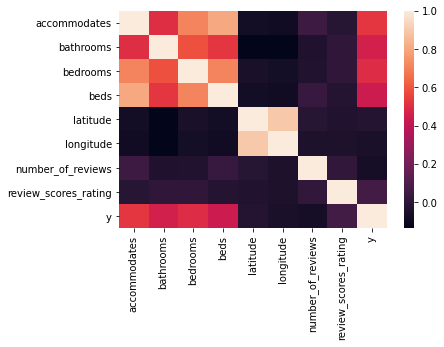

In [135]:
#相関係数のヒートマップ
corr_tr = df_train_addEDA.corr()
corr_tr = pd.DataFrame(corr_tr)
sns.heatmap(corr_tr)

In [136]:
#目的変数と高い相関を持つ特徴量を確認
high_corr = corr_tr[np.abs(corr_tr['y']) > 0.5]['y']
high_corr

accommodates    0.52233
y               1.00000
Name: y, dtype: float64

In [140]:
#目的変数と高い相関を持つ特徴量を確認
low_corr = corr_tr[np.abs(corr_tr['y']) > 0.3]['y']
low_corr

accommodates    0.522330
bathrooms       0.456044
bedrooms        0.495830
beds            0.435603
y               1.000000
Name: y, dtype: float64

## 型ごとに分ける

In [37]:
#目的変数と特徴量に分ける
train_y = train["y"]
train_X = train.drop("y", axis=1)

#定性データの定量データのカラムリストを作る
cat_col = [col for col in train_X.select_dtypes(include=object)]
num_col = [col for col in train_X.select_dtypes(exclude=object)]

In [39]:
train_X.columns

Index(['accommodates', 'amenities', 'bathrooms', 'bed_type', 'bedrooms',
       'beds', 'cancellation_policy', 'city', 'cleaning_fee', 'description',
       'first_review', 'host_has_profile_pic', 'host_identity_verified',
       'host_response_rate', 'host_since', 'instant_bookable', 'last_review',
       'latitude', 'longitude', 'name', 'neighbourhood', 'number_of_reviews',
       'property_type', 'review_scores_rating', 'room_type', 'thumbnail_url',
       'zipcode'],
      dtype='object')

## 目的変数

In [226]:
#目的変数であるホテルの価格の要約統計量を表示する
train_y.describe()

count    55583.000000
mean       160.163647
std        168.087140
min          1.000000
25%         74.000000
50%        111.000000
75%        185.000000
max       1999.000000
Name: y, dtype: float64

### y

<AxesSubplot:xlabel='y', ylabel='Count'>

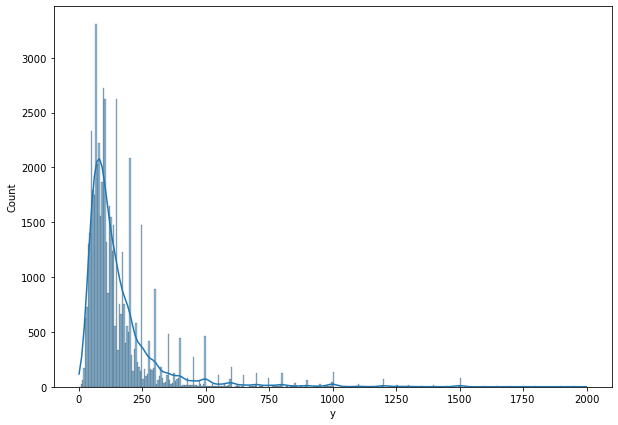

In [187]:
plt.figure(figsize=(10, 7))
sns.histplot(train_y, kde=True)
# sns.histplot(train_y, kde=True)

In [180]:
#歪度と尖度を計算
print("歪度: %f" % train_y.skew())
print("尖度: %f" % train_y.kurt())

歪度: 4.264338
尖度: 26.030945


### log_y

歪度: 0.535099
尖度: 0.662021


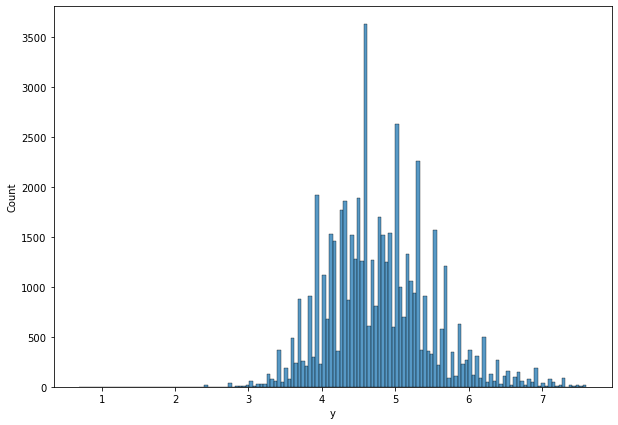

In [230]:
#目的変数の対数log(x+1)をとる
train_y_log = np.log1p(train_y)

#分布を可視化
plt.figure(figsize=(10, 7))
sns.histplot(train_y_log)

#歪度と尖度を計算
print("歪度: %f" % train_y_log.skew())
print("尖度: %f" % train_y_log.kurt())

### y / accommodates

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


歪度: 8.806298
尖度: 160.913907


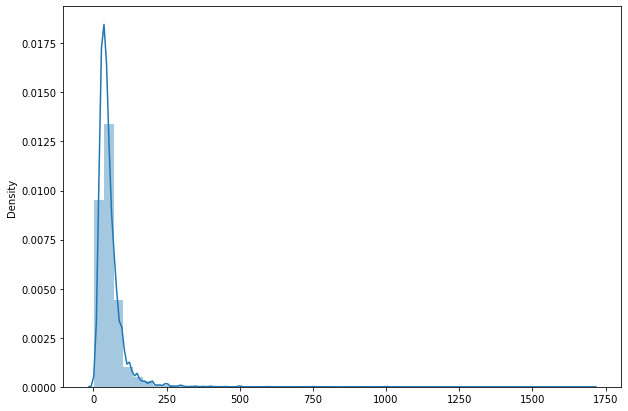

In [227]:
#目的変数の対数log(x+1)をとる
train_y_ac = train_y / train["accommodates"]

#分布を可視化
plt.figure(figsize=(10, 7))
sns.distplot(train_y_ac)

#歪度と尖度を計算
print("歪度: %f" % train_y_ac.skew())
print("尖度: %f" % train_y_ac.kurt())

### log_(y / accommodates)

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


歪度: 0.340463
尖度: 1.541811


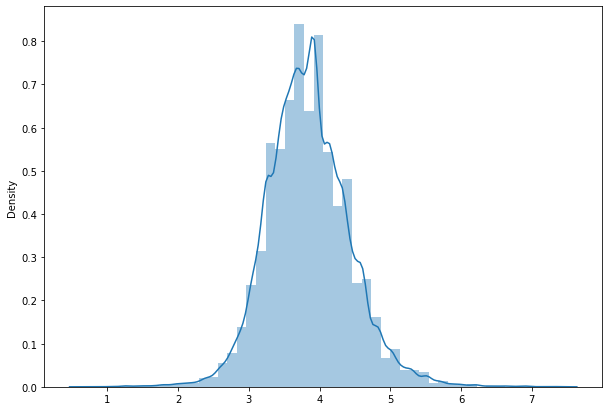

In [228]:
#目的変数の対数log(x+1)をとる
train_y_ac_log = np.log1p(train_y_ac)

#分布を可視化
plt.figure(figsize=(10, 7))
sns.distplot(train_y_ac_log)

#歪度と尖度を計算
print("歪度: %f" % train_y_ac_log.skew())
print("尖度: %f" % train_y_ac_log.kurt())

## オブジェクト型の以外の利用

<Figure size 432x288 with 0 Axes>

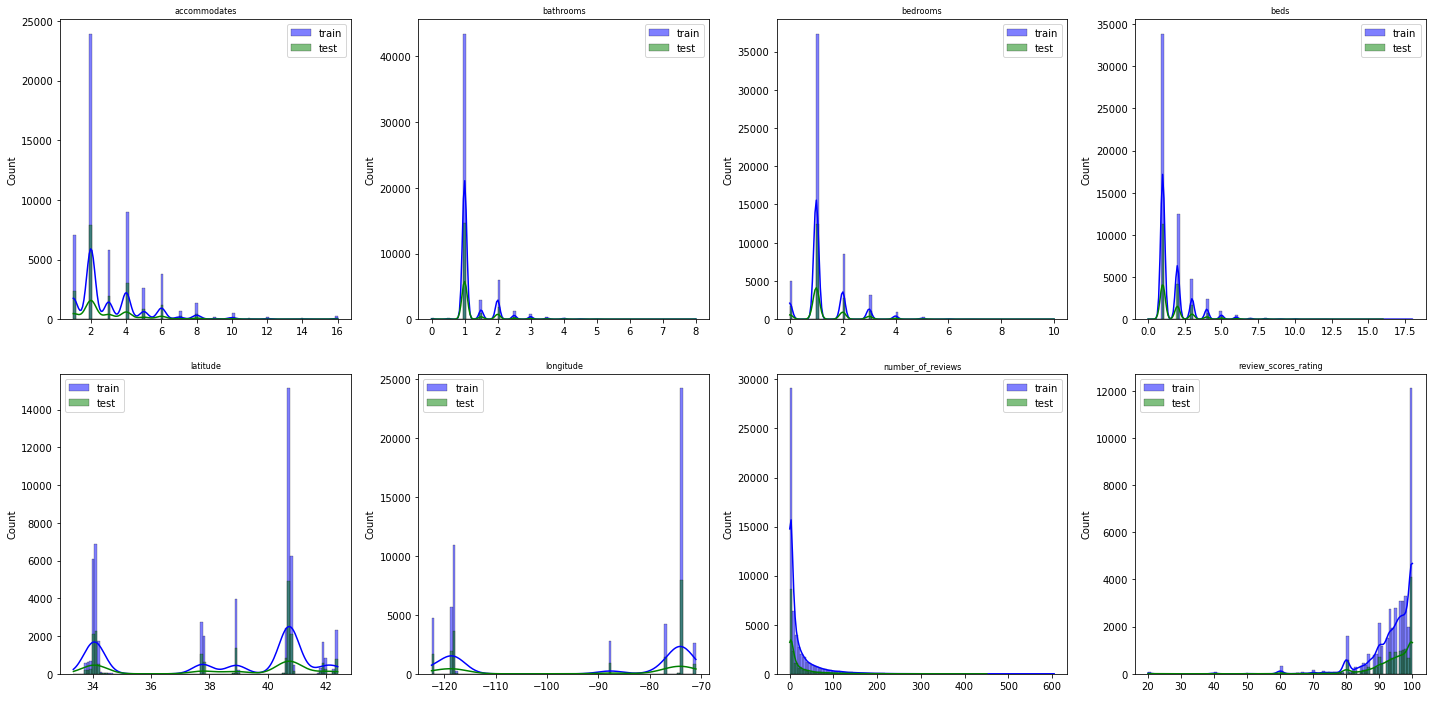

In [182]:
#ヒストグラム
i = 1
plt.figure()
fig, ax = plt.subplots(2, 4, figsize=(20,10))

for feature in num_col:
    plt.subplot(2,4,i)
    sns.histplot(train[feature], color='blue', kde=True, bins=100, 
                label='train')
    sns.histplot(test_x[feature], color='green', kde=True, bins=100, 
                label='test')
    plt.title(feature, fontsize=8)
    plt.xlabel(' ')
    plt.legend()
    i += 1
plt.tight_layout()
plt.show()

### accommodates

Text(0, 0.5, 'y')

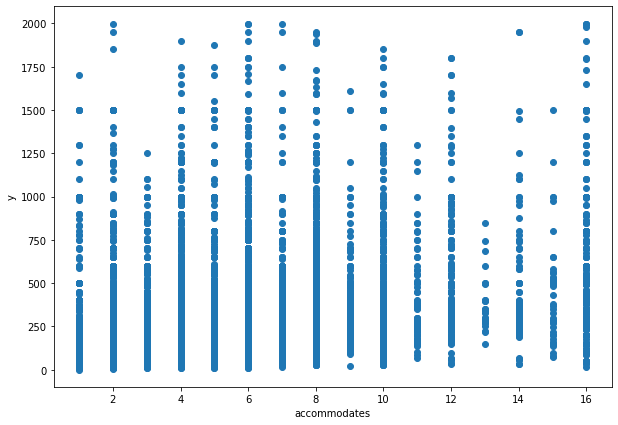

In [191]:
#収容人数とホテルの値段の散布図を作成
plt.figure(figsize=(10, 7))
plt.scatter(train["accommodates"], train_y)
plt.xlabel("accommodates")
plt.ylabel("y")

Text(0, 0.5, 'y')

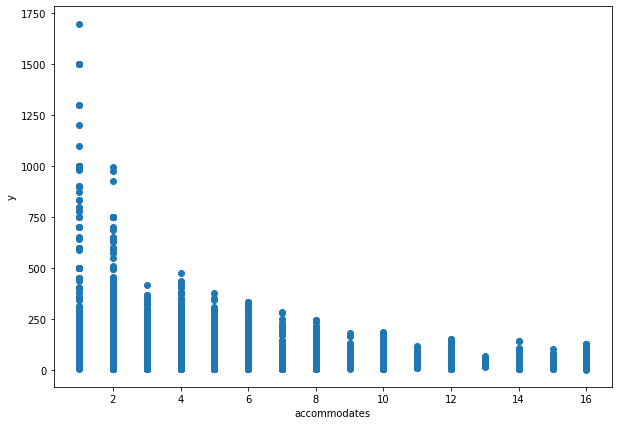

In [192]:
#収容人数とホテルの値段の散布図を作成
plt.figure(figsize=(10, 7))
plt.scatter(train["accommodates"], train_y/train["accommodates"])
plt.xlabel("accommodates")
plt.ylabel("y")

Text(0, 0.5, 'y_log')

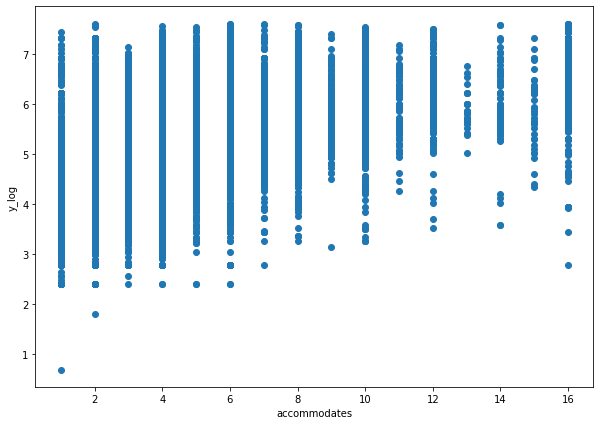

In [193]:
##収容人数とホテルの値段の散布図を作成
plt.figure(figsize=(10, 7))
plt.scatter(train["accommodates"], train_y_log)
plt.xlabel("accommodates")
plt.ylabel("y_log")

Text(0, 0.5, 'y_log')

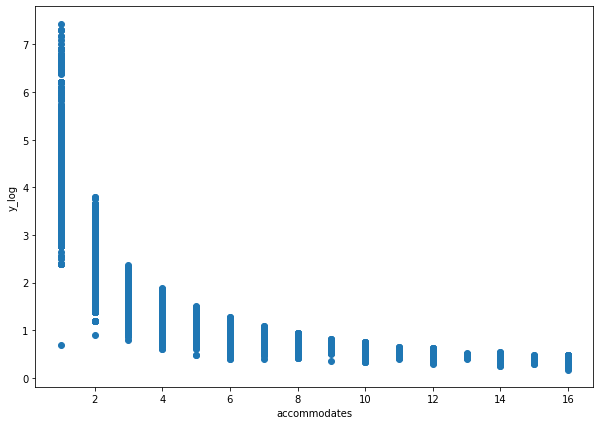

In [194]:
#収容人数とホテルの値段の散布図を作成
plt.figure(figsize=(10, 7))
plt.scatter(train["accommodates"], train_y_log/train["accommodates"])
plt.xlabel("accommodates")
plt.ylabel("y_log")

### bathrooms

In [23]:
train["bathrooms"].value_counts()

1.0    43469
2.0     6042
1.5     2875
2.5     1186
3.0      793
3.5      308
4.0      223
0.0      156
0.5      154
4.5       82
5.0       49
8.0       37
5.5       28
6.0       14
6.5        8
7.0        8
7.5        4
Name: bathrooms, dtype: int64

Text(0, 0.5, 'y')

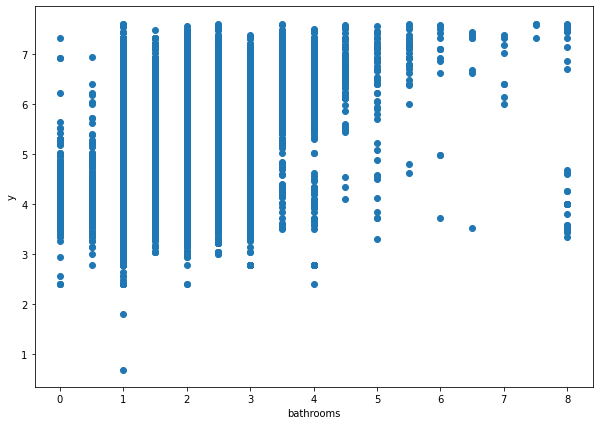

In [199]:
#物件の広さと物件価格の散布図を作成
plt.figure(figsize=(10, 7))
plt.scatter(train["bathrooms"], train_y_log)
plt.xlabel("bathrooms")
plt.ylabel("y")

Text(0, 0.5, 'y')

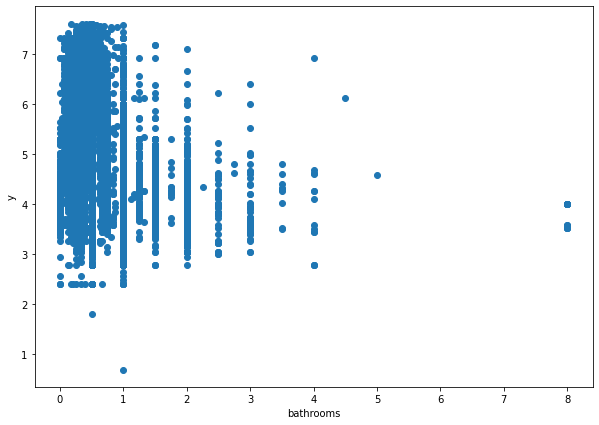

In [207]:
df_train_addEDA["bathrooms_par_1"] = train["bathrooms"] / train["accommodates"]
#物件の広さと物件価格の散布図を作成
plt.figure(figsize=(10, 7))
plt.scatter(df_train_addEDA["bathrooms_par_1"], train_y_log)
plt.xlabel("bathrooms")
plt.ylabel("y")

### bedrooms

In [24]:
train["bedrooms"].value_counts(dropna=False)

1.0     37338
2.0      8575
0.0      5016
3.0      3195
4.0       994
5.0       267
6.0        78
NaN        71
7.0        26
8.0        10
10.0        9
9.0         4
Name: bedrooms, dtype: int64

Text(0, 0.5, 'y')

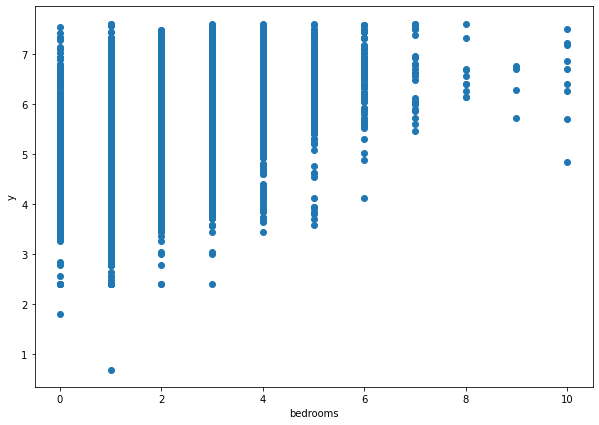

In [198]:
#物件の広さと物件価格の散布図を作成
plt.figure(figsize=(10, 7))
plt.scatter(train["bedrooms"], train_y_log)
plt.xlabel("bedrooms")
plt.ylabel("y")

In [ ]:
#築年数と物件価格の散布図を作成
#plt.scatter(train["YearBuilt"],train["SalePrice"],color = "#e41a1c")
#plt.xlabel("YearBuilt")
#plt.ylabel("SalePrice")

data = pd.concat([train["YearBuilt"],train["SalePrice"]],axis=1)

plt.figure(figsize=(20, 10))
plt.xticks(rotation='90')
sns.boxplot(x="YearBuilt",y="SalePrice",data=data)

Text(0, 0.5, 'y')

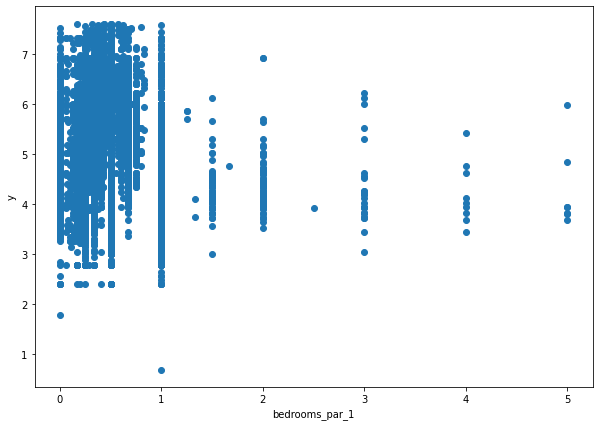

In [209]:
df_train_addEDA["bedrooms_par_1"] = train["bedrooms"] / train["accommodates"]
#物件の広さと物件価格の散布図を作成
plt.figure(figsize=(10, 7))
plt.scatter(df_train_addEDA["bedrooms_par_1"], train_y_log)
plt.xlabel("bedrooms_par_1")
plt.ylabel("y")

### beds

In [26]:
train["beds"].value_counts(dropna=False)

1.0     33863
2.0     12526
3.0      4805
4.0      2341
5.0       942
6.0       490
7.0       174
8.0       141
NaN        96
10.0       62
9.0        56
16.0       31
12.0       21
11.0       19
13.0        8
15.0        4
14.0        2
18.0        1
0.0         1
Name: beds, dtype: int64

Text(0, 0.5, 'y')

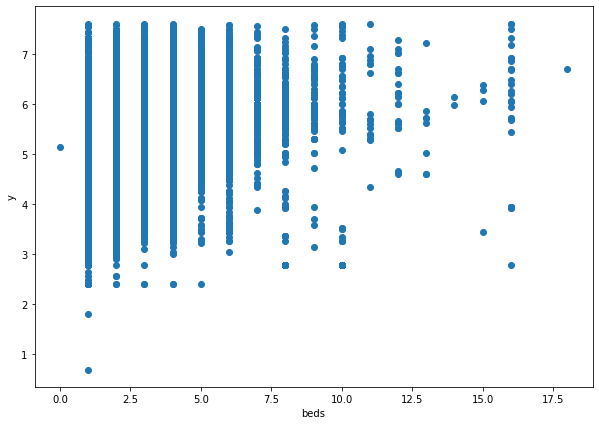

In [212]:
#物件の広さと物件価格の散布図を作成
plt.figure(figsize=(10, 7))
plt.scatter(train["beds"], train_y_log)
plt.xlabel("beds")
plt.ylabel("y")

Text(0, 0.5, 'y')

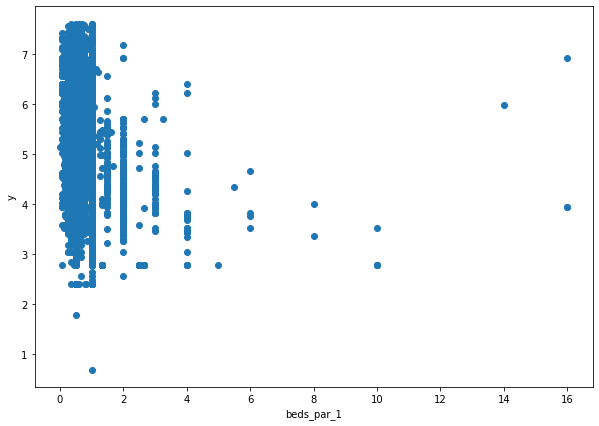

In [213]:
df_train_addEDA["beds_par_1"] = train["beds"] / train["accommodates"]
#物件の広さと物件価格の散布図を作成
plt.figure(figsize=(10, 7))
plt.scatter(df_train_addEDA["beds_par_1"], train_y_log)
plt.xlabel("beds_par_1")
plt.ylabel("y")

Text(0, 0.5, 'y')

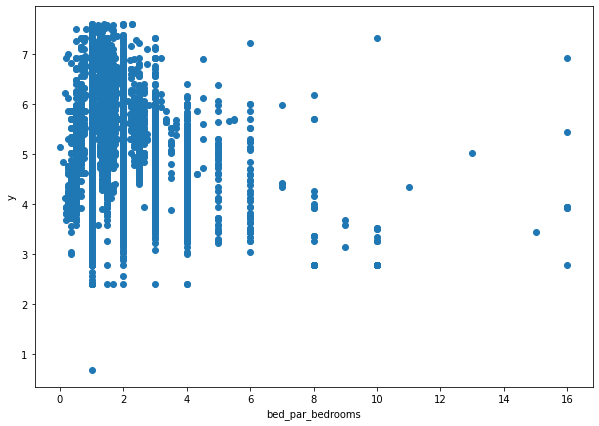

In [214]:
df_train_addEDA["bed_par_bedrooms"] = train["beds"] / train["bedrooms"]
#物件の広さと物件価格の散布図を作成
plt.figure(figsize=(10, 7))
plt.scatter(df_train_addEDA["bed_par_bedrooms"], train_y_log)
plt.xlabel("bed_par_bedrooms")
plt.ylabel("y")

### latitude

In [27]:
train["latitude"].astype(int).value_counts()

40    24326
34    13158
37     4768
38     4259
33     3670
41     2709
42     2693
Name: latitude, dtype: int64

Text(0, 0.5, 'y')

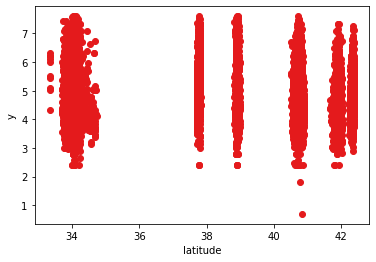

In [218]:
plt.scatter(train["latitude"],train_y_log,color = "#e41a1c")
plt.xlabel("latitude")
plt.ylabel("y")

In [33]:
# #築年数と物件価格の散布図を作成
# data = pd.concat([train["latitude"],train_y_log],axis=1)

# plt.figure(figsize=(20, 10))
# plt.xticks(rotation='90')
# sns.boxplot(x="latitude",y="y",data=data)

### longitude

In [28]:
train["longitude"].astype(int).value_counts()

-73     22609
-118    16213
-122     4768
-77      3191
-87      2807
-71      2594
-74      1717
-76      1068
-117      615
-70         1
Name: longitude, dtype: int64

Text(0, 0.5, 'y')

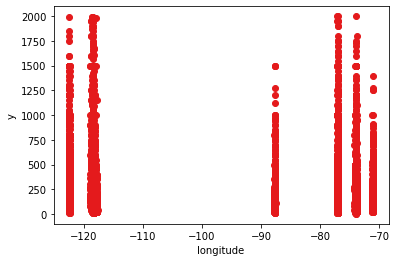

In [30]:
plt.scatter(train["longitude"],train_y,color = "#e41a1c")
plt.xlabel("longitude")
plt.ylabel("y")

### number_of_reviews

In [35]:
train["number_of_reviews"].value_counts(dropna=False)

0      11873
1       5306
2       3528
3       2742
4       2192
5       1932
6       1519
7       1383
8       1254
9       1083
10      1010
11       874
12       801
13       776
14       747
15       700
16       622
18       567
17       531
19       525
20       470
21       460
23       425
22       420
24       403
26       400
25       361
28       353
27       335
29       325
31       315
32       299
30       280
36       275
33       269
34       259
35       257
37       231
38       212
41       212
39       202
44       198
40       196
45       184
42       182
43       179
46       174
49       173
47       172
48       164
51       164
50       158
55       157
52       144
58       141
56       140
54       138
53       134
57       133
61       129
59       126
64       120
63       118
60       116
67       116
62       115
66       113
69       113
71       113
65       100
70        97
74        96
76        87
75        85
68        85
84        83
81        80

In [43]:
train["number_of_reviews"].sum()

1163757

Text(0, 0.5, 'y')

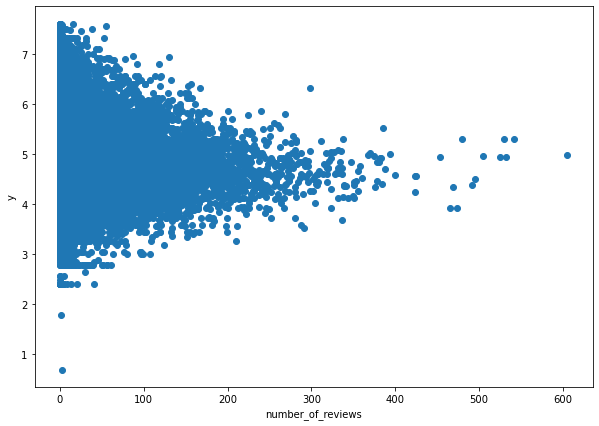

In [215]:
#物件の広さと物件価格の散布図を作成
plt.figure(figsize=(10, 7))
plt.scatter(train["number_of_reviews"], train_y_log)
plt.xlabel("number_of_reviews")
plt.ylabel("y")

### review_scores_rating

In [42]:
train["review_scores_rating"].value_counts(dropna=False)

NaN      12556
100.0    12110
98.0      3301
96.0      3100
97.0      3085
95.0      2794
93.0      2735
90.0      2147
99.0      1971
94.0      1952
80.0      1598
92.0      1528
91.0      1194
89.0       850
87.0       838
88.0       800
85.0       478
86.0       368
84.0       346
60.0       333
83.0       300
70.0       146
82.0       145
73.0       126
81.0        96
75.0        81
20.0        70
78.0        69
40.0        68
79.0        64
76.0        58
67.0        56
77.0        56
74.0        28
72.0        25
50.0        23
65.0        15
68.0        12
69.0        10
71.0        10
63.0         9
64.0         6
53.0         5
62.0         3
57.0         3
47.0         3
27.0         2
55.0         2
30.0         2
66.0         2
35.0         1
49.0         1
58.0         1
54.0         1
Name: review_scores_rating, dtype: int64

Text(0, 0.5, 'y')

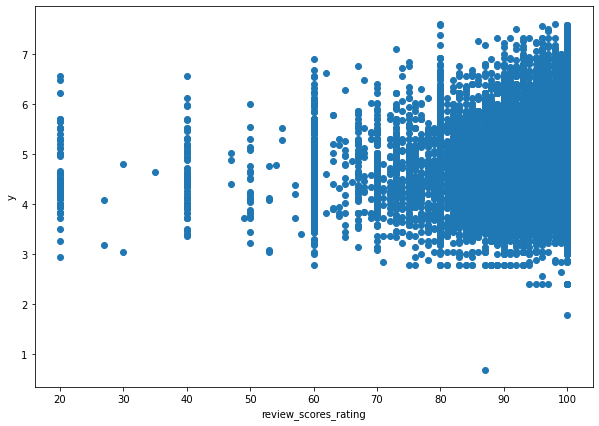

In [216]:
plt.figure(figsize=(10, 7))
plt.scatter(train["review_scores_rating"], train_y_log)
plt.xlabel("review_scores_rating")
plt.ylabel("y")

## オブジェクト型の利用

In [12]:
train_ob = train.select_dtypes(include=object)
train_ob.head()

amenities  bed_type  \
0  {TV,"Wireless Internet",Kitchen,"Free parking ...  Real Bed   
1  {TV,"Cable TV",Internet,"Wireless Internet","A...  Real Bed   
2  {TV,Internet,"Wireless Internet",Kitchen,"Indo...  Real Bed   
3  {TV,"Cable TV",Internet,"Wireless Internet","A...  Real Bed   
4  {TV,Internet,"Wireless Internet","Air conditio...  Real Bed   

  cancellation_policy city cleaning_fee  \
0            flexible   LA            t   
1              strict   DC            t   
2              strict  NYC            t   
3              strict   SF            t   
4              strict  NYC            t   

                                         description first_review  \
0  My place is meant for family and a few friends...   2016-07-27   
1  This is a new listing for a lovely guest bedro...   2016-09-12   
2  We're looking forward to your stay at our apt....   2016-06-15   
3  BEST CITY VIEWS - - ROOF DECK W/ BBQ & WiFi - ...   2014-03-15   
4  Charming Apartment on the upper west side of M...   2015-08-05   

  host_has_profile_pic host_identity_verified host_response_rate  host_since  \
0                    t                      f                NaN  2016-07-13   
1                    t                      t               100%  2015-12-30   
2                    t                      f               100%  2016-05-21   
3                    t                      t               100%  2012-06-19   
4                    t                      t               100%  2015-03-25   

  instant_bookable last_review  \
0                f  2016-07-27   
1                f  2017-03-31   
2                t  2017-08-13   
3                t  2017-09-03   
4                f  2017-09-10   

                                                name    neighbourhood  \
0                                      The Penthouse              NaN   
1                         Guest Bedroom in Brookland        Brookland   
2  Clean Modern Room in Lux Apt 1 Block From J Train         Bushwick   
3               BEST views + reviews! 5/5 stars*****         Nob Hill   
4                 Charming 1-bedroom - UWS Manhattan  Upper West Side   

  property_type        room_type  \
0     Apartment     Private room   
1         House     Private room   
2     Apartment     Private room   
3     Apartment     Private room   
4     Apartment  Entire home/apt   

                                       thumbnail_url zipcode  
0                                                NaN   90804  
1  https://a0.muscache.com/im/pictures/e4d8b51f-6...   20018  
2  https://a0.muscache.com/im/pictures/5ffecc9b-d...     NaN  
3                                                NaN   94133  
4  https://a0.muscache.com/im/pictures/92879730/5...   10024

In [46]:
train_ob.columns

Index(['amenities', 'bed_type', 'cancellation_policy', 'city', 'cleaning_fee',
       'description', 'first_review', 'host_has_profile_pic',
       'host_identity_verified', 'host_response_rate', 'host_since',
       'instant_bookable', 'last_review', 'name', 'neighbourhood',
       'property_type', 'room_type', 'thumbnail_url', 'zipcode'],
      dtype='object')

### amenities

|カラム|ヘッダ名称|データ型|説明|
|-|-|-|-|
|2|	amenities|	char|	アメニティ|

In [20]:
train_ob['amenities_文字数'] = train_ob['amenities'].apply(lambda x: len(x))
# .replace('{', '').replace('}', '').replace('"', '').split(',')

In [123]:
train_ob['amenities_文字数'] = train_ob["amenities"].apply(lambda x: x.count('"'))

0         6
1        24
2        32
3        18
4        16
         ..
55578    12
55579    18
55580    14
55581    16
55582    28
Name: amenities, Length: 55583, dtype: int64

In [106]:
train_ob.sort_values('amenities_文字列', ascending=False).head()

amenities  bed_type  \
42565  {TV,"Cable TV","Wireless Internet","Air condit...  Real Bed   
7523   {TV,"Cable TV","Wireless Internet","Air condit...  Real Bed   
9932   {TV,"Cable TV",Internet,"Wireless Internet","A...  Real Bed   
51136  {TV,"Cable TV",Internet,"Wireless Internet","A...  Real Bed   
9842   {TV,"Cable TV",Internet,"Wireless Internet","A...  Real Bed   

      cancellation_policy city cleaning_fee  \
42565            flexible   SF            f   
7523               strict  NYC            t   
9932               strict   SF            t   
51136              strict  NYC            t   
9842               strict  NYC            f   

                                             description first_review  \
42565  This is a memorable property in one of San Fra...          NaN   
7523   Brand new, renovated, beautifully furnished 2 ...   2017-06-15   
9932   We are a professional couple offering our huge...   2016-05-07   
51136  Before submitting a reservation requests (by c...   2016-10-30   
9842   The apartment is right off of 8th Avenue near ...   2016-02-12   

      host_has_profile_pic host_identity_verified host_response_rate  \
42565                    t                      t               100%   
7523                     t                      t                97%   
9932                     t                      f               100%   
51136                    t                      t                93%   
9842                     t                      t               100%   

       host_since instant_bookable last_review  \
42565  2017-05-30                t         NaN   
7523   2017-05-30                f  2017-09-24   
9932   2012-06-11                t  2017-09-23   
51136  2016-09-27                f  2017-09-28   
9842   2015-08-17                f  2017-08-31   

                                                    name  \
42565  Ocean view 2bd Apartment,North Beach,San Franc...   
7523     Brand New, Spacious & Sunny 2 Bedroom Apartment   
9932          Sunny Designer Room in Luxury SF Apartment   
51136     Brand New 1 Bedroom Apartment With Sunny Patio   
9842   Brand New 1 Bedroom Apartment Next To Times Sq...   

                       neighbourhood property_type        room_type  \
42565                 Telegraph Hill     Apartment  Entire home/apt   
7523                  Hell's Kitchen     Apartment  Entire home/apt   
9932                     Mission Bay     Apartment     Private room   
51136                 Hell's Kitchen     Apartment  Entire home/apt   
9842   Times Square/Theatre District     Apartment  Entire home/apt   

                                           thumbnail_url zipcode  \
42565  https://a0.muscache.com/im/pictures/f342f785-f...   94133   
7523                                                 NaN   10019   
9932   https://a0.muscache.com/im/pictures/10df2f00-4...   94158   
51136  https://a0.muscache.com/im/pictures/f697e2c5-9...   10036   
9842   https://a0.muscache.com/im/pictures/7af0735c-e...   10019   

       amenities_文字列  
42565           1496  
7523            1179  
9932            1175  
51136           1168  
9842            1157

In [109]:
train_ob['amenities'].iloc[42565]

'{TV,"Cable TV","Wireless Internet","Air conditioning",Kitchen,"Free parking on premises","Pets allowed",Breakfast,Elevator,"Hot tub","Indoor fireplace",Heating,"Family/kid friendly","Suitable for events",Washer,Dryer,"Smoke detector","Carbon monoxide detector","First aid kit","Safety card","Fire extinguisher",Essentials,Shampoo,"Lock on bedroom door",Hangers,"Hair dryer",Iron,"Laptop friendly workspace","Self Check-In",Keypad,"Private entrance","Baby monitor",Bathtub,"Baby bath","Changing table","Children’s books and toys","Window guards","Table corner guards","Fireplace guards","Babysitter recommendations",Crib,"Room-darkening shades","Game console","Hot water","Bed linens","Extra pillows and blankets","Ethernet connection","Pocket wifi",Microwave,"Coffee maker",Refrigerator,Dishwasher,"Dishes and silverware","Cooking basics",Oven,Stove,"EV charger","Single level home","BBQ grill","Patio or balcony","Garden or backyard","Beach essentials","Luggage dropoff allowed","Long term stays al

In [99]:
train_ob['amenities'].head()

0    {TV,"Wireless Internet",Kitchen,"Free parking ...
1    {TV,"Cable TV",Internet,"Wireless Internet","A...
2    {TV,Internet,"Wireless Internet",Kitchen,"Indo...
3    {TV,"Cable TV",Internet,"Wireless Internet","A...
4    {TV,Internet,"Wireless Internet","Air conditio...
Name: amenities, dtype: object

In [113]:
A = train_ob['amenities'][4]
A

'{TV,Internet,"Wireless Internet","Air conditioning",Kitchen,Elevator,"Buzzer/wireless intercom",Heating,Washer,Dryer,"Smoke detector","Carbon monoxide detector","Safety card","Fire extinguisher",Essentials,Shampoo,Hangers,"Hair dryer"}'

In [114]:
A = train_ob['amenities'][42565]
A

'{TV,"Cable TV","Wireless Internet","Air conditioning",Kitchen,"Free parking on premises","Pets allowed",Breakfast,Elevator,"Hot tub","Indoor fireplace",Heating,"Family/kid friendly","Suitable for events",Washer,Dryer,"Smoke detector","Carbon monoxide detector","First aid kit","Safety card","Fire extinguisher",Essentials,Shampoo,"Lock on bedroom door",Hangers,"Hair dryer",Iron,"Laptop friendly workspace","Self Check-In",Keypad,"Private entrance","Baby monitor",Bathtub,"Baby bath","Changing table","Children’s books and toys","Window guards","Table corner guards","Fireplace guards","Babysitter recommendations",Crib,"Room-darkening shades","Game console","Hot water","Bed linens","Extra pillows and blankets","Ethernet connection","Pocket wifi",Microwave,"Coffee maker",Refrigerator,Dishwasher,"Dishes and silverware","Cooking basics",Oven,Stove,"EV charger","Single level home","BBQ grill","Patio or balcony","Garden or backyard","Beach essentials","Luggage dropoff allowed","Long term stays al

In [117]:
A.replace('{', '').replace('}', '').split(',')
# .replace('"', '')

['TV',
 '"Cable TV"',
 '"Wireless Internet"',
 '"Air conditioning"',
 'Kitchen',
 '"Free parking on premises"',
 '"Pets allowed"',
 'Breakfast',
 'Elevator',
 '"Hot tub"',
 '"Indoor fireplace"',
 'Heating',
 '"Family/kid friendly"',
 '"Suitable for events"',
 'Washer',
 'Dryer',
 '"Smoke detector"',
 '"Carbon monoxide detector"',
 '"First aid kit"',
 '"Safety card"',
 '"Fire extinguisher"',
 'Essentials',
 'Shampoo',
 '"Lock on bedroom door"',
 'Hangers',
 '"Hair dryer"',
 'Iron',
 '"Laptop friendly workspace"',
 '"Self Check-In"',
 'Keypad',
 '"Private entrance"',
 '"Baby monitor"',
 'Bathtub',
 '"Baby bath"',
 '"Changing table"',
 '"Children’s books and toys"',
 '"Window guards"',
 '"Table corner guards"',
 '"Fireplace guards"',
 '"Babysitter recommendations"',
 'Crib',
 '"Room-darkening shades"',
 '"Game console"',
 '"Hot water"',
 '"Bed linens"',
 '"Extra pillows and blankets"',
 '"Ethernet connection"',
 '"Pocket wifi"',
 'Microwave',
 '"Coffee maker"',
 'Refrigerator',
 'Dishwash

In [97]:
train_ob['amenities'][2].replace('{', '').replace('}', '').replace('"', '').split(',')

['TV',
 'Internet',
 'Wireless Internet',
 'Kitchen',
 'Indoor fireplace',
 'Buzzer/wireless intercom',
 'Heating',
 'Washer',
 'Dryer',
 'Smoke detector',
 'Carbon monoxide detector',
 'First aid kit',
 'Safety card',
 'Fire extinguisher',
 'Essentials',
 'Shampoo',
 'Lock on bedroom door',
 '24-hour check-in',
 'Hangers',
 'Hair dryer',
 'Iron',
 'Laptop friendly workspace',
 'translation missing: en.hosting_amenity_49',
 'translation missing: en.hosting_amenity_50',
 'Self Check-In',
 'Keypad',
 'Lockbox',
 'Bathtub',
 'Room-darkening shades']

In [93]:
train_ob['amenities'][4].replace('{', '').replace('}', '').replace('"', '').split(',')

['TV',
 'Internet',
 'Wireless Internet',
 'Air conditioning',
 'Kitchen',
 'Elevator',
 'Buzzer/wireless intercom',
 'Heating',
 'Washer',
 'Dryer',
 'Smoke detector',
 'Carbon monoxide detector',
 'Safety card',
 'Fire extinguisher',
 'Essentials',
 'Shampoo',
 'Hangers',
 'Hair dryer']

In [87]:
A = train_ob['amenities'][0].replace('{', '{"').replace(',"', '":"')
A

'{"TV":"Wireless Internet",Kitchen":"Free parking on premises",Washer,Dryer":"Smoke detector"}'

In [ ]:
.replace(',"', '":"').replace('",', '":"').replace(',', '","').replace('"', "'")

In [380]:
# train_ob['amenities'].value_counts()

In [208]:
# amenity = train["amenities"].iloc[2]

In [209]:
# amenity_type =  amenity.split('{')[1].split('}')[0].split(',')
# amenity_type

In [210]:
# len(amenity_type)

In [391]:
s = df_train_addEDA["amenities"].copy()

def count_amenity(x):
    return len(str(x).split('{')[1].split('}')[0].split(','))

df_train_addEDA['amenities_count'] = s.map(count_amenity)
df_train_addEDA.drop(['amenities'], axis=1, inplace=True)
df_train_addEDA.head()

id  accommodates  bathrooms  bed_type  bedrooms  beds cancellation_policy  \
0   0             6        2.0  Real Bed       1.0   4.0            flexible   
1   1             2        1.0  Real Bed       1.0   1.0              strict   
2   2             2        2.0  Real Bed       1.0   1.0              strict   
3   3             2        1.0  Real Bed       1.0   1.0              strict   
4   4             2        1.0  Real Bed       1.0   1.0              strict   

  city cleaning_fee                                        description  \
0   LA            t  My place is meant for family and a few friends...   
1   DC            t  This is a new listing for a lovely guest bedro...   
2  NYC            t  We're looking forward to your stay at our apt....   
3   SF            t  BEST CITY VIEWS - - ROOF DECK W/ BBQ & WiFi - ...   
4  NYC            t  Charming Apartment on the upper west side of M...   

  first_review host_has_profile_pic host_identity_verified host_response_rate  \
0   2016-07-27                    t                      f                NaN   
1   2016-09-12                    t                      t               100%   
2   2016-06-15                    t                      f               100%   
3   2014-03-15                    t                      t               100%   
4   2015-08-05                    t                      t               100%   

   host_since instant_bookable last_review   latitude   longitude  \
0  2016-07-13                f  2016-07-27  33.788931 -118.154761   
1  2015-12-30                f  2017-03-31  38.934810  -76.978190   
2  2016-05-21                t  2017-08-13  40.695118  -73.926240   
3  2012-06-19                t  2017-09-03  37.796728 -122.411906   
4  2015-03-25                f  2017-09-10  40.785050  -73.974691   

                                                name    neighbourhood  \
0                                      The Penthouse              NaN   
1                         Guest Bedroom in Brookland        Brookland   
2  Clean Modern Room in Lux Apt 1 Block From J Train         Bushwick   
3               BEST views + reviews! 5/5 stars*****         Nob Hill   
4                 Charming 1-bedroom - UWS Manhattan  Upper West Side   

   number_of_reviews property_type  review_scores_rating        room_type  \
0                  1     Apartment                  60.0     Private room   
1                  9         House                 100.0     Private room   
2                 27     Apartment                  83.0     Private room   
3                 38     Apartment                  95.0     Private room   
4                  5     Apartment                 100.0  Entire home/apt   

                                       thumbnail_url zipcode      y  \
0                                                NaN   90804  138.0   
1  https://a0.muscache.com/im/pictures/e4d8b51f-6...   20018   42.0   
2  https://a0.muscache.com/im/pictures/5ffecc9b-d...     NaN   65.0   
3                                                NaN   94133  166.0   
4  https://a0.muscache.com/im/pictures/92879730/5...   10024  165.0   

   amenities_count  
0                7  
1               22  
2               29  
3               18  
4               18

=============================================================

In [25]:
train_ob['amenities_split'] = train_ob['amenities'].apply(lambda x: x.replace('{', '').replace('}', '').split(','))
train_ob['amenities_split'].head()

0    [TV, "Wireless Internet", Kitchen, "Free parki...
1    [TV, "Cable TV", Internet, "Wireless Internet"...
2    [TV, Internet, "Wireless Internet", Kitchen, "...
3    [TV, "Cable TV", Internet, "Wireless Internet"...
4    [TV, Internet, "Wireless Internet", "Air condi...
Name: amenities_split, dtype: object

In [43]:
train_ob.sort_values('amenities_文字数', ascending=False).index[0]

42565

In [28]:
A = train_ob['amenities_split'][42565]
A

['TV',
 '"Cable TV"',
 '"Wireless Internet"',
 '"Air conditioning"',
 'Kitchen',
 '"Free parking on premises"',
 '"Pets allowed"',
 'Breakfast',
 'Elevator',
 '"Hot tub"',
 '"Indoor fireplace"',
 'Heating',
 '"Family/kid friendly"',
 '"Suitable for events"',
 'Washer',
 'Dryer',
 '"Smoke detector"',
 '"Carbon monoxide detector"',
 '"First aid kit"',
 '"Safety card"',
 '"Fire extinguisher"',
 'Essentials',
 'Shampoo',
 '"Lock on bedroom door"',
 'Hangers',
 '"Hair dryer"',
 'Iron',
 '"Laptop friendly workspace"',
 '"Self Check-In"',
 'Keypad',
 '"Private entrance"',
 '"Baby monitor"',
 'Bathtub',
 '"Baby bath"',
 '"Changing table"',
 '"Children’s books and toys"',
 '"Window guards"',
 '"Table corner guards"',
 '"Fireplace guards"',
 '"Babysitter recommendations"',
 'Crib',
 '"Room-darkening shades"',
 '"Game console"',
 '"Hot water"',
 '"Bed linens"',
 '"Extra pillows and blankets"',
 '"Ethernet connection"',
 '"Pocket wifi"',
 'Microwave',
 '"Coffee maker"',
 'Refrigerator',
 'Dishwash

In [29]:
B = train_ob['amenities_split'][7523]
B

['TV',
 '"Cable TV"',
 '"Wireless Internet"',
 '"Air conditioning"',
 '"Wheelchair accessible"',
 'Kitchen',
 '"Pets allowed"',
 'Breakfast',
 'Elevator',
 '"Buzzer/wireless intercom"',
 'Heating',
 '"Family/kid friendly"',
 'Washer',
 'Dryer',
 '"Smoke detector"',
 '"Carbon monoxide detector"',
 '"First aid kit"',
 '"Safety card"',
 '"Fire extinguisher"',
 'Essentials',
 'Shampoo',
 '"Lock on bedroom door"',
 'Hangers',
 '"Hair dryer"',
 'Iron',
 '"Laptop friendly workspace"',
 '"Self Check-In"',
 'Lockbox',
 'Doorman',
 '"Baby monitor"',
 '"Outlet covers"',
 'Bathtub',
 '"Baby bath"',
 '"Changing table"',
 '"High chair"',
 '"Window guards"',
 '"Table corner guards"',
 '"Pack ’n Play/travel crib"',
 '"Room-darkening shades"',
 '"Children’s dinnerware"',
 '"Hot water"',
 '"Bed linens"',
 '"Extra pillows and blankets"',
 '"Ethernet connection"',
 '"Pocket wifi"',
 'Microwave',
 '"Coffee maker"',
 'Refrigerator',
 'Dishwasher',
 '"Dishes and silverware"',
 '"Cooking basics"',
 'Oven',
 '

In [40]:
for i in B:
    print(i)

TV
"Cable TV"
"Wireless Internet"
"Air conditioning"
"Wheelchair accessible"
Kitchen
"Pets allowed"
Breakfast
Elevator
"Buzzer/wireless intercom"
Heating
"Family/kid friendly"
Washer
Dryer
"Smoke detector"
"Carbon monoxide detector"
"First aid kit"
"Safety card"
"Fire extinguisher"
Essentials
Shampoo
"Lock on bedroom door"
Hangers
"Hair dryer"
Iron
"Laptop friendly workspace"
"Self Check-In"
Lockbox
Doorman
"Baby monitor"
"Outlet covers"
Bathtub
"Baby bath"
"Changing table"
"High chair"
"Window guards"
"Table corner guards"
"Pack ’n Play/travel crib"
"Room-darkening shades"
"Children’s dinnerware"
"Hot water"
"Bed linens"
"Extra pillows and blankets"
"Ethernet connection"
"Pocket wifi"
Microwave
"Coffee maker"
Refrigerator
Dishwasher
"Dishes and silverware"
"Cooking basics"
Oven
Stove
"EV charger"
"Single level home"
"Luggage dropoff allowed"
"Wide hallway clearance"
"Step-free access"
"Wide doorway"
"Flat
 smooth pathway to front door"
"Well-lit path to entrance"
"Step-free access"
"W

In [44]:
train_ob['amenities'].str.contains(B[10])

0        False
1         True
2         True
3         True
4         True
         ...  
55578     True
55579     True
55580     True
55581     True
55582     True
Name: amenities, Length: 55583, dtype: bool

In [41]:
train_ob['amenities'].str.contains(B[10]).value_counts()

True     50328
False     5255
Name: amenities, dtype: int64

In [38]:
train_ob['amenities'].str.contains('Cable TV')

0        False
1         True
2        False
3         True
4        False
         ...  
55578     True
55579    False
55580    False
55581    False
55582     True
Name: amenities, Length: 55583, dtype: bool

### bed_type

In [226]:
train_ob['bed_type'].value_counts()

Real Bed         53989
Futon              569
Pull-out Sofa      453
Airbed             364
Couch              208
Name: bed_type, dtype: int64

### cancellation_policy

In [227]:
train_ob['cancellation_policy'].value_counts()

strict             24318
flexible           16886
moderate           14288
super_strict_30       78
super_strict_60       13
Name: cancellation_policy, dtype: int64

### city

In [228]:
train_ob['city'].value_counts()

NYC        24326
LA         16828
SF          4768
DC          4259
Chicago     2807
Boston      2595
Name: city, dtype: int64

### cleaning_fee 

In [229]:
train_ob['cleaning_fee'].value_counts()

t    40821
f    14762
Name: cleaning_fee, dtype: int64

### description

In [230]:
# train_ob['description'][3]

In [231]:
# len(train_ob['description'][3])

In [232]:
train_ob['description'].head()

0    My place is meant for family and a few friends...
1    This is a new listing for a lovely guest bedro...
2    We're looking forward to your stay at our apt....
3    BEST CITY VIEWS - - ROOF DECK W/ BBQ & WiFi - ...
4    Charming Apartment on the upper west side of M...
Name: description, dtype: object

In [233]:
df_train_addEDA['description_word_count'] = train_ob['description'].map(lambda x: len(x))
df_train_addEDA.drop(['description'], axis=1, inplace=True)
df_train_addEDA.head()

id  accommodates  bathrooms  bed_type  bedrooms  beds cancellation_policy  \
0   0             6        2.0  Real Bed       1.0   4.0            flexible   
1   1             2        1.0  Real Bed       1.0   1.0              strict   
2   2             2        2.0  Real Bed       1.0   1.0              strict   
3   3             2        1.0  Real Bed       1.0   1.0              strict   
4   4             2        1.0  Real Bed       1.0   1.0              strict   

  city cleaning_fee host_has_profile_pic  ... review_scores_rating  \
0   LA            t                    t  ...                 60.0   
1   DC            t                    t  ...                100.0   
2  NYC            t                    t  ...                 83.0   
3   SF            t                    t  ...                 95.0   
4  NYC            t                    t  ...                100.0   

         room_type                                      thumbnail_url zipcode  \
0     Private room                                                NaN   90804   
1     Private room  https://a0.muscache.com/im/pictures/e4d8b51f-6...   20018   
2     Private room  https://a0.muscache.com/im/pictures/5ffecc9b-d...     NaN   
3     Private room                                                NaN   94133   
4  Entire home/apt  https://a0.muscache.com/im/pictures/92879730/5...   10024   

  first_review_Year  first_review_Month  first_review_Day BusinessOld  \
0            2016.0                 7.0              27.0     -2809.0   
1            2016.0                 9.0              12.0     -2856.0   
2            2016.0                 6.0              15.0     -2767.0   
3            2014.0                 3.0              15.0     -1944.0   
4            2015.0                 8.0               5.0     -2452.0   

  amenities_count  description_word_count  
0               7                     379  
1              22                     406  
2              29                     467  
3              18                    1000  
4              18                    1000  

[5 rows x 31 columns]

### first_review

In [234]:
df_train_addEDA['first_review'] = pd.to_datetime(train_ob['first_review'])
df_train_addEDA['first_review'].head()

0   2016-07-27
1   2016-09-12
2   2016-06-15
3   2014-03-15
4   2015-08-05
Name: first_review, dtype: datetime64[ns]

In [235]:
df_train_addEDA["first_review_Year"] = df_train_addEDA["first_review"].apply(lambda x:x.year)
df_train_addEDA["first_review_Month"] = df_train_addEDA["first_review"].apply(lambda x:x.month)
df_train_addEDA["first_review_Day"] = df_train_addEDA["first_review"].apply(lambda x:x.day)
df_train_addEDA["kijun"] = "2008-11-17"
df_train_addEDA["kijun"] = pd.to_datetime(df_train_addEDA["kijun"])
df_train_addEDA["BusinessOld"] = (df_train_addEDA["kijun"] - df_train_addEDA["first_review"]).apply(lambda x: x.days)

df_train_addEDA = df_train_addEDA.drop('first_review', axis=1)
df_train_addEDA = df_train_addEDA.drop('kijun', axis=1)

In [236]:
df_train_addEDA.head()

id  accommodates  bathrooms  bed_type  bedrooms  beds cancellation_policy  \
0   0             6        2.0  Real Bed       1.0   4.0            flexible   
1   1             2        1.0  Real Bed       1.0   1.0              strict   
2   2             2        2.0  Real Bed       1.0   1.0              strict   
3   3             2        1.0  Real Bed       1.0   1.0              strict   
4   4             2        1.0  Real Bed       1.0   1.0              strict   

  city cleaning_fee host_has_profile_pic  ... review_scores_rating  \
0   LA            t                    t  ...                 60.0   
1   DC            t                    t  ...                100.0   
2  NYC            t                    t  ...                 83.0   
3   SF            t                    t  ...                 95.0   
4  NYC            t                    t  ...                100.0   

         room_type                                      thumbnail_url zipcode  \
0     Private room                                                NaN   90804   
1     Private room  https://a0.muscache.com/im/pictures/e4d8b51f-6...   20018   
2     Private room  https://a0.muscache.com/im/pictures/5ffecc9b-d...     NaN   
3     Private room                                                NaN   94133   
4  Entire home/apt  https://a0.muscache.com/im/pictures/92879730/5...   10024   

  first_review_Year  first_review_Month  first_review_Day BusinessOld  \
0            2016.0                 7.0              27.0     -2809.0   
1            2016.0                 9.0              12.0     -2856.0   
2            2016.0                 6.0              15.0     -2767.0   
3            2014.0                 3.0              15.0     -1944.0   
4            2015.0                 8.0               5.0     -2452.0   

  amenities_count  description_word_count  
0               7                     379  
1              22                     406  
2              29                     467  
3              18                    1000  
4              18                    1000  

[5 rows x 31 columns]

In [ ]:
data = pd.concat([train["YearBuilt"],train["SalePrice"]],axis=1)

plt.figure(figsize=(20, 10))
plt.xticks(rotation='90')
sns.boxplot(x="YearBuilt",y="SalePrice",data=data)

### host_has_profile_pic

In [237]:
train_ob['host_has_profile_pic'].value_counts()

t    55265
f      170
Name: host_has_profile_pic, dtype: int64

### host_identity_verified

In [238]:
train_ob['host_identity_verified'].value_counts()

t    37264
f    18171
Name: host_identity_verified, dtype: int64

### host_response_rate

In [239]:
train_ob['host_response_rate'].value_counts()

100%    32510
90%      1666
80%       824
0%        660
50%       464
        ...  
6%          1
31%         1
21%         1
15%         1
39%         1
Name: host_response_rate, Length: 78, dtype: int64

In [299]:
df_train_addEDA['host_response_rate'] =\
    train_ob['host_response_rate'].str.split("%", expand=True)[0].astype('int', errors='ignore')

df_train_addEDA['host_response_rate'] = df_train_addEDA['host_response_rate'].fillna(0).astype('int')
df_train_addEDA['host_response_rate'].head()

0      0
1    100
2    100
3    100
4    100
Name: host_response_rate, dtype: int64

In [300]:
df_train_addEDA['host_response_rate'].value_counts(dropna=False)

100    32510
0      14364
90      1666
80       824
50       464
       ...  
6          1
31         1
21         1
15         1
39         1
Name: host_response_rate, Length: 78, dtype: int64

### host_since

In [396]:
df_train_addEDA['host_since'] = pd.to_datetime(train_ob['host_since'])
df_train_addEDA['host_since'].head()

0   2016-07-13
1   2015-12-30
2   2016-05-21
3   2012-06-19
4   2015-03-25
Name: host_since, dtype: datetime64[ns]

In [397]:
df_train_addEDA['host_since'].head()

0   2016-07-13
1   2015-12-30
2   2016-05-21
3   2012-06-19
4   2015-03-25
Name: host_since, dtype: datetime64[ns]

In [398]:
df_train_addEDA['host_since'].min()

Timestamp('2008-03-03 00:00:00')

In [ ]:
# df_train_addEDA['first_review'] = pd.to_datetime(train_ob['first_review'])
# df_train_addEDA["last_review_Year"] = df_train_addEDA["last_review"].apply(lambda x:x.year)
# df_train_addEDA["last_review_Month"] = df_train_addEDA["last_review"].apply(lambda x:x.month)
# df_train_addEDA["last_review_Day"] = df_train_addEDA["last_review"].apply(lambda x:x.day)
# df_train_addEDA["kijun"] = "2008-11-17"
# df_train_addEDA["kijun"] = pd.to_datetime(df_train_addEDA["kijun"])
# df_train_addEDA["BusinessOld2"] = (df_train_addEDA["kijun"] - df_train_addEDA["last_review"]).apply(lambda x: x.days)
# df_train_addEDA["BusinessPeriod"] = (df_train_addEDA["first_review"] - df_train_addEDA["last_review"]).apply(lambda x: x.days)

# df_train_addEDA = df_train_addEDA.drop('first_review', axis=1)
# df_train_addEDA = df_train_addEDA.drop('last_review', axis=1)
# df_train_addEDA = df_train_addEDA.drop('kijun', axis=1)

### instant_bookable

In [242]:
train_ob['instant_bookable'].value_counts()

f    41034
t    14549
Name: instant_bookable, dtype: int64

### last_review

In [244]:
df_train_addEDA['last_review'] = pd.to_datetime(train_ob['last_review'])
df_train_addEDA['last_review'].head()

0   2016-07-27
1   2017-03-31
2   2017-08-13
3   2017-09-03
4   2017-09-10
Name: last_review, dtype: datetime64[ns]

In [246]:
df_train_addEDA['first_review'] = pd.to_datetime(train_ob['first_review'])
df_train_addEDA["last_review_Year"] = df_train_addEDA["last_review"].apply(lambda x:x.year)
df_train_addEDA["last_review_Month"] = df_train_addEDA["last_review"].apply(lambda x:x.month)
df_train_addEDA["last_review_Day"] = df_train_addEDA["last_review"].apply(lambda x:x.day)
df_train_addEDA["kijun"] = "2008-11-17"
df_train_addEDA["kijun"] = pd.to_datetime(df_train_addEDA["kijun"])
df_train_addEDA["BusinessOld2"] = (df_train_addEDA["kijun"] - df_train_addEDA["last_review"]).apply(lambda x: x.days)
df_train_addEDA["BusinessPeriod"] = (df_train_addEDA["first_review"] - df_train_addEDA["last_review"]).apply(lambda x: x.days)

df_train_addEDA = df_train_addEDA.drop('first_review', axis=1)
df_train_addEDA = df_train_addEDA.drop('last_review', axis=1)
df_train_addEDA = df_train_addEDA.drop('kijun', axis=1)

### name

In [248]:
train_ob['name'].head()
df_train_addEDA = df_train_addEDA.drop('name', axis=1)

### neighbourhood

In [249]:
train_ob['neighbourhood'].head()

0                NaN
1          Brookland
2           Bushwick
3           Nob Hill
4    Upper West Side
Name: neighbourhood, dtype: object

In [364]:
train_ob['neighbourhood'].value_counts()

Williamsburg                           2189
Bedford-Stuyvesant                     1615
Bushwick                               1208
Upper West Side                        1075
Mid-Wilshire                           1058
Harlem                                  996
Hollywood                               983
Hell's Kitchen                          978
Venice                                  914
Upper East Side                         897
Crown Heights                           789
Astoria                                 661
Lower East Side                         645
East Village                            610
Mission District                        577
East Harlem                             577
Washington Heights                      556
Chelsea                                 550
Greenpoint                              538
West Hollywood                          532
Hamilton Heights                        474
West Village                            474
Clinton Hill                    

### property_type

In [250]:
train_ob['property_type'].value_counts()

Apartment             36826
House                 12326
Condominium            1983
Townhouse              1249
Loft                    914
Other                   448
Guesthouse              392
Bed & Breakfast         349
Bungalow                281
Villa                   131
Dorm                    112
Guest suite              96
Camper/RV                71
In-law                   60
Timeshare                55
Boat                     53
Hostel                   51
Boutique hotel           50
Cabin                    47
Serviced apartment       16
Tent                     14
Vacation home            11
Castle                    9
Yurt                      8
Hut                       7
Treehouse                 7
Chalet                    4
Earth House               4
Tipi                      3
Train                     2
Cave                      1
Island                    1
Parking Space             1
Casa particular           1
Name: property_type, dtype: int64

### room_type

In [251]:
train_ob['room_type'].value_counts()

Entire home/apt    30939
Private room       23023
Shared room         1621
Name: room_type, dtype: int64

### thumbnail_url

In [252]:
train_ob['thumbnail_url'].head()

0                                                  NaN
1    https://a0.muscache.com/im/pictures/e4d8b51f-6...
2    https://a0.muscache.com/im/pictures/5ffecc9b-d...
3                                                  NaN
4    https://a0.muscache.com/im/pictures/92879730/5...
Name: thumbnail_url, dtype: object

In [253]:
train_ob['thumbnail_url'].value_counts()

https://a0.muscache.com/im/pictures/70087089/bc66229a_original.jpg?aki_policy=small              3
https://a0.muscache.com/im/pictures/105275678/2ec252ae_original.jpg?aki_policy=small             2
https://a0.muscache.com/im/pictures/623a5884-0613-4cbd-962f-bbd28c7f47bc.jpg?aki_policy=small    2
https://a0.muscache.com/im/pictures/95059281/d8bfc436_original.jpg?aki_policy=small              2
https://a0.muscache.com/im/pictures/109405834/9a555e66_original.jpg?aki_policy=small             2
                                                                                                ..
https://a0.muscache.com/im/pictures/047a2350-fd75-4b21-a17c-e637823d1818.jpg?aki_policy=small    1
https://a0.muscache.com/im/pictures/801a391f-3477-408b-beb4-eed14842ae12.jpg?aki_policy=small    1
https://a0.muscache.com/im/pictures/e1340e6e-a395-4814-8d45-a9f6782414d6.jpg?aki_policy=small    1
https://a0.muscache.com/im/pictures/c57736e7-4227-46b7-9a7b-48556ffccf67.jpg?aki_policy=small    1
https://a0

In [259]:
df_train_addEDA['thumbnail_url'][df_train_addEDA['thumbnail_url'].notnull()] = 1

/var/folders/g6/qtvrbqf960v1l069d_0yh2lc0000gn/T/ipykernel_95165/227975015.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ori_train['thumbnail_url'][df_ori_train['thumbnail_url'].notnull()] = 1


In [261]:
df_train_addEDA.head()

id  accommodates  bathrooms  bed_type  bedrooms  beds cancellation_policy  \
0   0             6        2.0  Real Bed       1.0   4.0            flexible   
1   1             2        1.0  Real Bed       1.0   1.0              strict   
2   2             2        2.0  Real Bed       1.0   1.0              strict   
3   3             2        1.0  Real Bed       1.0   1.0              strict   
4   4             2        1.0  Real Bed       1.0   1.0              strict   

  city cleaning_fee host_has_profile_pic  ... first_review_Month  \
0   LA            t                    t  ...                7.0   
1   DC            t                    t  ...                9.0   
2  NYC            t                    t  ...                6.0   
3   SF            t                    t  ...                3.0   
4  NYC            t                    t  ...                8.0   

  first_review_Day BusinessOld amenities_count  description_word_count  \
0             27.0     -2809.0               7                     379   
1             12.0     -2856.0              22                     406   
2             15.0     -2767.0              29                     467   
3             15.0     -1944.0              18                    1000   
4              5.0     -2452.0              18                    1000   

   last_review_Year last_review_Month  last_review_Day BusinessOld2  \
0            2016.0               7.0             27.0      -2809.0   
1            2017.0               3.0             31.0      -3056.0   
2            2017.0               8.0             13.0      -3191.0   
3            2017.0               9.0              3.0      -3212.0   
4            2017.0               9.0             10.0      -3219.0   

   BusinessPeriod  
0             0.0  
1          -200.0  
2          -424.0  
3         -1268.0  
4          -767.0  

[5 rows x 34 columns]

### zipcode

In [262]:
train_ob['zipcode'].head()

0    90804
1    20018
2      NaN
3    94133
4    10024
Name: zipcode, dtype: object

In [275]:
train_ob['zipcode'].isnull().sum()

716

In [337]:
train_ob['zipcode'].value_counts()

11211.0                     1065
90291                        948
11221                        885
20002                        714
94110                        713
90046                        704
20009                        698
20001                        608
90028                        602
10002                        576
10019                        572
11222                        545
90026                        543
10009.0                      542
10025                        532
90036                        485
10036                        484
11237                        478
11215                        478
10027                        461
11216                        461
10031                        453
11206                        452
10014                        439
10029.0                      400
90068                        398
94114                        395
10012                        389
10016                        385
10011.0                      378
11238.0   

In [357]:
zipcode = train_ob['zipcode'].str.replace('Near', '').str.replace('m', '').replace(' ', np.nan).str.split("\r", expand=True)[0].str.split("-", expand=True)[0].str.split(".", expand=True)[0]

In [358]:
df_train_addEDA['zipcode_int'] = zipcode
df_train_addEDA['zipcode_int'] = df_train_addEDA['zipcode_int'].fillna(0)
df_train_addEDA['zipcode_int'] = df_train_addEDA['zipcode_int'].astype(int)
# df_train_addEDA = df_train_addEDA.drop('zipcode', axis=1)

In [359]:
df_train_addEDA['zipcode_int'].value_counts(dropna=False)

11211    1251
90291     948
11221     893
11206     785
10002     743
0         718
20002     714
94110     713
11216     705
90046     704
20009     698
11238     669
10009     648
20001     608
90028     602
10003     601
10019     573
11222     570
11237     545
90026     543
10025     533
90036     486
10011     485
10036     484
11215     479
10027     467
10031     453
10014     451
94117     420
10029     403
94114     398
90068     398
11249     391
10012     390
10016     386
11233     382
11205     370
94109     360
11226     354
90066     354
11225     352
20003     345
11217     314
10024     294
10032     291
90038     290
90292     289
90025     285
10023     284
90027     284
94103     282
90019     282
90069     278
20010     277
11201     274
90048     272
60647     263
10026     259
20011     258
10013     257
90034     250
60622     246
11213     242
10128     242
94107     241
10001     236
90024     236
11207     235
94115     235
2116      231
2130      230
90004 

### 説明変数を対数変換

https://medium-s.jp/kaggle-house-prices/

Index(['accommodates', 'bathrooms', 'bedrooms', 'beds', 'latitude',
       'longitude', 'number_of_reviews', 'review_scores_rating', 'y'],
      dtype='object')


<AxesSubplot:>

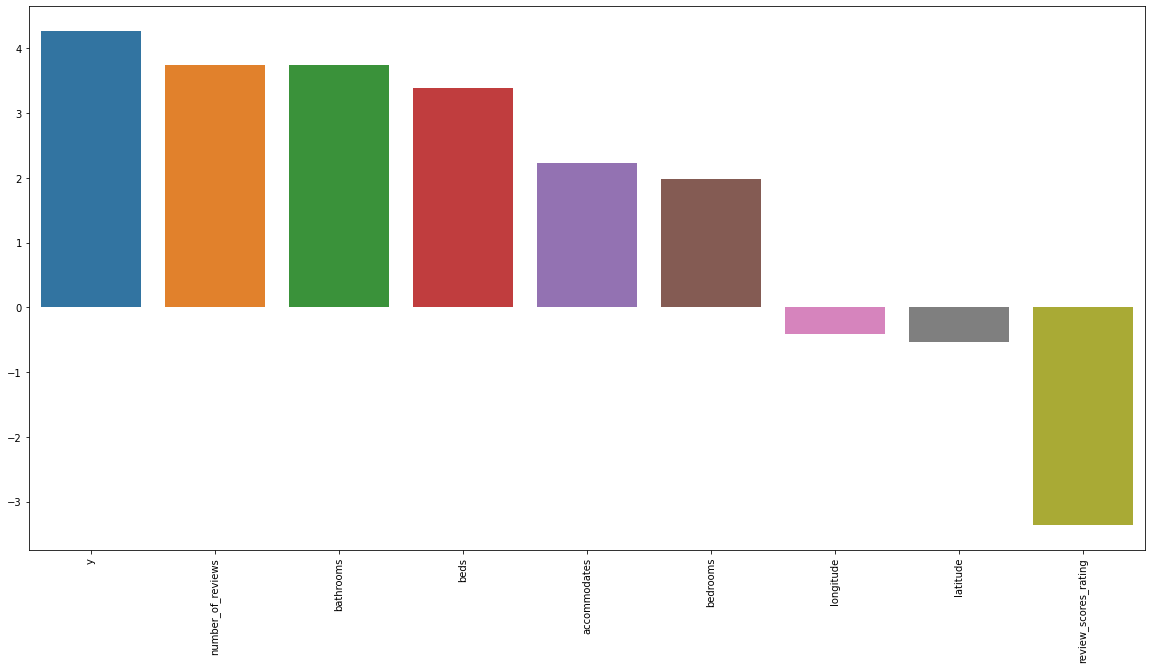

In [48]:
#数値の説明変数のリストを作成
num_feats = df_train_addEDA.dtypes[df_train_addEDA.dtypes != "object" ].index
print(num_feats)

#各説明変数の歪度を計算
skewed_feats = df_train_addEDA[num_feats].apply(lambda x: x.skew()).sort_values(ascending = False)

#グラフ化
plt.figure(figsize=(20,10))
plt.xticks(rotation='90')
sns.barplot(x=skewed_feats.index, y=skewed_feats)

In [47]:
#歪度の絶対値が0.5より大きい変数だけに絞る
skewed_feats_over = skewed_feats[abs(skewed_feats) > 0.5].index

#各変数の最小値を表示
for i in skewed_feats_over:
    print(min(df_train_addEDA[i]))

1.0
0
0.0
0.0
1
0.0
33.33890467150096
20.0


<AxesSubplot:>

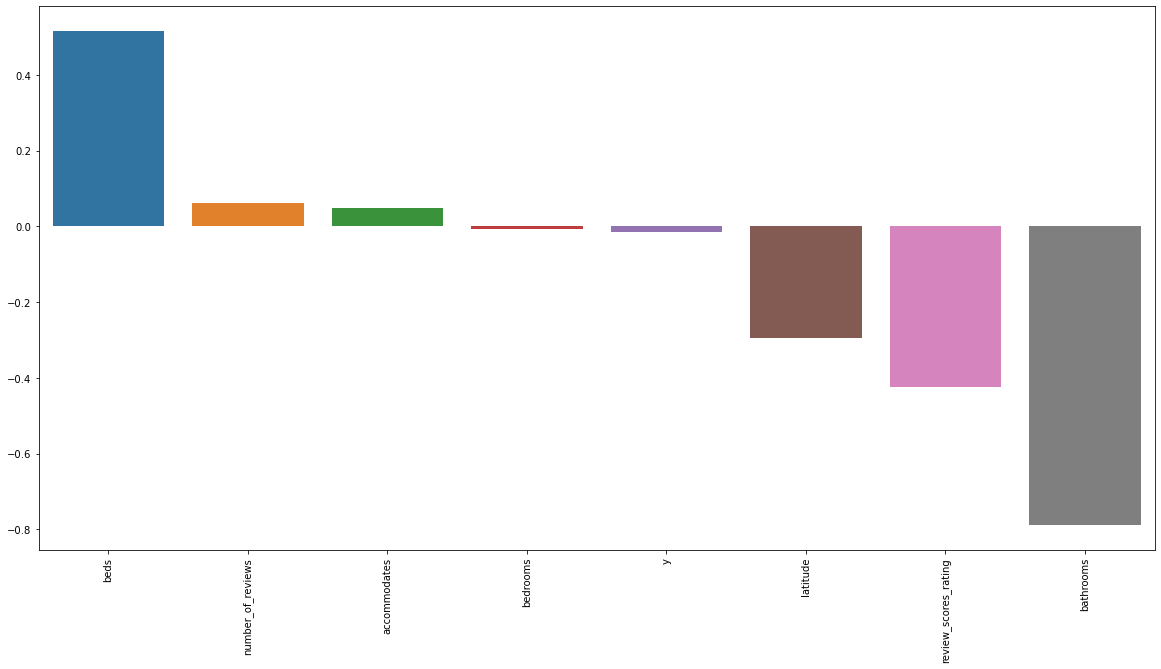

In [134]:
#Yeo-Johnson変換
pt = PowerTransformer()
pt.fit(df_train_addEDA[skewed_feats_over])

#変換後のデータで各列を置換
df_train_addEDA[skewed_feats_over] = pt.transform(df_train_addEDA[skewed_feats_over])

#各説明変数の歪度を計算
skewed_feats_fixed = df_train_addEDA[skewed_feats_over].apply(lambda x: x.skew()).sort_values(ascending = False)

#グラフ化
plt.figure(figsize=(20,10))
plt.xticks(rotation='90')
sns.barplot(x=skewed_feats_fixed.index, y=skewed_feats_fixed)

# トレーニング

## 前処理

In [42]:
df_train_addEDA = preprocessing(train)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [44]:
#one-hot変換をせずにlabelencodingする → カテゴリ変数化
categorical_columns = ['neighbourhood']

In [45]:
df_dummy_train = process_categorical(df_train_addEDA, categorical_columns)

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 154.55it/s]


In [46]:
df_dummy_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55583 entries, 0 to 55582
Data columns (total 90 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   accommodates                         55583 non-null  float64 
 1   bathrooms                            55436 non-null  float64 
 2   bedrooms                             55512 non-null  float64 
 3   beds                                 55487 non-null  float64 
 4   host_response_rate                   55583 non-null  float64 
 5   latitude                             55583 non-null  float64 
 6   longitude                            55583 non-null  float64 
 7   neighbourhood                        55583 non-null  category
 8   number_of_reviews                    55583 non-null  float64 
 9   review_scores_rating                 43027 non-null  float64 
 10  amenities_count                      55583 non-null  float64 
 11  description_wor

In [47]:
df_dummy_train.head()

accommodates  bathrooms  bedrooms  beds  host_response_rate   latitude  \
0           6.0        2.0       1.0   4.0                 0.0  33.788931   
1           2.0        1.0       1.0   1.0               100.0  38.934810   
2           2.0        2.0       1.0   1.0               100.0  40.695118   
3           2.0        1.0       1.0   1.0               100.0  37.796728   
4           2.0        1.0       1.0   1.0               100.0  40.785050   

    longitude neighbourhood  number_of_reviews  review_scores_rating  \
0 -118.154761           375                1.0                  60.0   
1  -76.978190            72                9.0                 100.0   
2  -73.926240            82               27.0                  83.0   
3 -122.411906           385               38.0                  95.0   
4  -73.974691           547                5.0                 100.0   

   amenities_count  description_word_count  first_review_Year  \
0              7.0                   379.0             2016.0   
1             22.0                   406.0             2016.0   
2             29.0                   467.0             2016.0   
3             18.0                  1000.0             2014.0   
4             18.0                  1000.0             2015.0   

   first_review_Month  first_review_Day  BusinessOld  host_since_Year  \
0                 7.0              27.0       2809.0           2016.0   
1                 9.0              12.0       2856.0           2015.0   
2                 6.0              15.0       2767.0           2016.0   
3                 3.0              15.0       1944.0           2012.0   
4                 8.0               5.0       2452.0           2015.0   

   host_since_Month  host_since_Day  BusinessOld2  first_reviewOld  \
0               7.0            13.0        3054.0             14.0   
1              12.0            30.0        2858.0            257.0   
2               5.0            21.0        3001.0             25.0   
3               6.0            19.0        1569.0            634.0   
4               3.0            25.0        2578.0            133.0   

   last_review_Year  last_review_Month  last_review_Day  BusinessOld3  \
0            2016.0                7.0             27.0        2809.0   
1            2017.0                3.0             31.0        3056.0   
2            2017.0                8.0             13.0        3191.0   
3            2017.0                9.0              3.0        3212.0   
4            2017.0                9.0             10.0        3219.0   

   BusinessUpdate  BusinessPeriod  zipcode_int  bed_type_Airbed  \
0          1982.0             0.0      90804.0                0   
1          1735.0           200.0      20018.0                0   
2          1600.0           424.0          0.0                0   
3          1579.0          1268.0      94133.0                0   
4          1572.0           767.0      10024.0                0   

   bed_type_Couch  bed_type_Futon  bed_type_Pull-out Sofa  bed_type_Real Bed  \
0               0               0                       0                  1   
1               0               0                       0                  1   
2               0               0                       0                  1   
3               0               0                       0                  1   
4               0               0                       0                  1   

   cancellation_policy_flexible  cancellation_policy_moderate  \
0                             1                             0   
1                             0                             0   
2                             0                             0   
3                             0                             0   
4                             0                             0   

   cancellation_policy_strict  cancellation_policy_super_strict_30  \
0                           0                                    0   
1 

## データセットを分ける

In [48]:
# xData = df_dummy_train.drop(['y'], axis=1)
# yData = df_dummy_train['y'].copy()

xData = df_dummy_train.copy()
yData = y

In [49]:
train_X, valid_X, train_y, valid_y = train_test_split(xData, yData, test_size=0.33, random_state=0)

## パラメータチューニング

In [50]:
import optuna.integration.lightgbm as op_lgb
from sklearn import datasets, model_selection

dtrain_tuning = op_lgb.Dataset(train_X.values, label=train_y.values)
dval_tuning = op_lgb.Dataset(valid_X.values, label=valid_y.values)

In [51]:
best_params, tuning_history = dict(), list()
# ハイパーパラメータサーチ&モデル構築(回帰モデル用)
tuning_params = {'objective': 'regression',
          'metric': 'rmse',
          'num_boost_round': 5000, # 最大試行数
          'random_seed':100,
         'learning_rate': 0.01, # 学習率
         }

booster = op_lgb.train(tuning_params, 
                       dtrain_tuning, 
                       valid_sets=[dtrain_tuning, dval_tuning],
                       verbose_eval=0,
                       early_stopping_rounds=20,)


[I 2021-07-24 14:44:09,223] A new study created in memory with name: no-name-8489d4e9-99d4-48bf-a187-95e092a3df5f
feature_fraction, val_score: inf:   0%|                   | 0/7 [00:00<?, ?it/s]Found `num_boost_round` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


feature_fraction, val_score: 105.886064:  14%|5   | 1/7 [00:24<02:27, 24.66s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


feature_fraction, val_score: 105.886064:  29%|#1  | 2/7 [00:48<01:59, 23.99s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


feature_fraction, val_score: 105.886064:  43%|#7  | 3/7 [01:08<01:28, 22.17s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004755 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


feature_fraction, val_score: 105.886064:  57%|##2 | 4/7 [01:27<01:03, 21.02s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


feature_fraction, val_score: 105.886064:  71%|##8 | 5/7 [01:53<00:45, 22.84s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


feature_fraction, val_score: 105.886064:  86%|###4| 6/7 [02:13<00:21, 21.80s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


num_leaves, val_score: 105.886064:   0%|                 | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


num_leaves, val_score: 105.565003:   5%|4        | 1/20 [00:36<11:27, 36.17s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


num_leaves, val_score: 105.565003:  10%|9        | 2/20 [01:05<09:40, 32.23s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


num_leaves, val_score: 105.565003:  15%|#3       | 3/20 [01:57<11:37, 41.00s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


num_leaves, val_score: 105.504315:  20%|#8       | 4/20 [02:51<12:20, 46.26s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


num_leaves, val_score: 105.504315:  25%|##2      | 5/20 [03:33<11:12, 44.81s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


num_leaves, val_score: 105.504315:  30%|##6      | 6/20 [04:07<09:34, 41.01s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


num_leaves, val_score: 105.504315:  35%|###1     | 7/20 [05:08<10:20, 47.71s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


num_leaves, val_score: 105.504315:  40%|###6     | 8/20 [05:35<08:10, 40.91s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


num_leaves, val_score: 105.504315:  45%|####     | 9/20 [06:21<07:49, 42.69s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


num_leaves, val_score: 105.504315:  50%|####    | 10/20 [06:47<06:13, 37.32s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


num_leaves, val_score: 105.504315:  55%|####4   | 11/20 [07:53<06:57, 46.39s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


num_leaves, val_score: 105.504315:  60%|####8   | 12/20 [08:30<05:47, 43.41s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


num_leaves, val_score: 105.504315:  65%|#####2  | 13/20 [09:14<05:05, 43.63s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


num_leaves, val_score: 105.504315:  70%|#####6  | 14/20 [09:55<04:16, 42.80s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


num_leaves, val_score: 105.504315:  75%|######  | 15/20 [10:24<03:13, 38.72s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


num_leaves, val_score: 105.504315:  80%|######4 | 16/20 [10:58<02:29, 37.30s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


num_leaves, val_score: 105.504315:  85%|######8 | 17/20 [12:04<02:17, 45.75s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


num_leaves, val_score: 105.504315:  90%|#######2| 18/20 [13:15<01:46, 53.31s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


num_leaves, val_score: 105.504315:  95%|#######6| 19/20 [13:48<00:47, 47.29s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


bagging, val_score: 105.504315:   0%|                    | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


bagging, val_score: 105.504315:  10%|#2          | 1/10 [00:28<04:17, 28.62s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


bagging, val_score: 105.504315:  20%|##4         | 2/10 [00:57<03:49, 28.68s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005719 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


bagging, val_score: 105.504315:  30%|###6        | 3/10 [01:29<03:33, 30.49s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


bagging, val_score: 105.504315:  40%|####8       | 4/10 [02:02<03:08, 31.43s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


bagging, val_score: 105.430908:  50%|######      | 5/10 [02:47<03:00, 36.06s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


bagging, val_score: 105.298256:  60%|#######2    | 6/10 [03:30<02:34, 38.54s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


bagging, val_score: 105.298256:  70%|########3   | 7/10 [03:52<01:38, 32.98s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


bagging, val_score: 105.298256:  80%|#########6  | 8/10 [04:17<01:00, 30.48s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003828 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


bagging, val_score: 105.298256:  90%|##########8 | 9/10 [04:48<00:30, 30.67s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


feature_fraction_stage2, val_score: 105.298256:   0%|     | 0/3 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


feature_fraction_stage2, val_score: 105.298256:  33%|3| 1/3 [00:31<01:02, 31.05s[I 2021-07-24 15:06:48,760] Trial 37 finished with value: 105.64339487403127 and parameters: {'feature_fraction': 0.41600000000000004}. Best is trial 37 with value: 105.64339487403127.
feature_fraction_stage2, val_score: 105.298256:  33%|3| 1/3 [00:31<01:02, 31.05s

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


feature_fraction_stage2, val_score: 105.298256:  67%|6| 2/3 [01:05<00:33, 33.08s[I 2021-07-24 15:07:23,257] Trial 38 finished with value: 105.77862835889132 and parameters: {'feature_fraction': 0.44800000000000006}. Best is trial 37 with value: 105.64339487403127.
feature_fraction_stage2, val_score: 105.298256:  67%|6| 2/3 [01:05<00:33, 33.08s

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


feature_fraction_stage2, val_score: 105.298256: 100%|#| 3/3 [01:44<00:00, 35.90s[I 2021-07-24 15:08:02,512] Trial 39 finished with value: 105.66084077891682 and parameters: {'feature_fraction': 0.48000000000000004}. Best is trial 37 with value: 105.64339487403127.
feature_fraction_stage2, val_score: 105.298256: 100%|#| 3/3 [01:44<00:00, 34.94s
regularization_factors, val_score: 105.298256:   0%|     | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


regularization_factors, val_score: 105.298256:   5%| | 1/20 [00:41<13:12, 41.73s[I 2021-07-24 15:08:44,250] Trial 40 finished with value: 105.30390528015823 and parameters: {'lambda_l1': 0.0014532148832116928, 'lambda_l2': 1.4366401868783805e-07}. Best is trial 40 with value: 105.30390528015823.
regularization_factors, val_score: 105.298256:   5%| | 1/20 [00:41<13:12, 41.73s

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004810 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


regularization_factors, val_score: 105.298256:  10%|1| 2/20 [01:20<11:57, 39.83s[I 2021-07-24 15:09:22,758] Trial 41 finished with value: 105.46594113713402 and parameters: {'lambda_l1': 2.3929458768083327, 'lambda_l2': 0.00019134509798523426}. Best is trial 40 with value: 105.30390528015823.
regularization_factors, val_score: 105.298256:  10%|1| 2/20 [01:20<11:57, 39.83s

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


regularization_factors, val_score: 105.298256:  15%|1| 3/20 [01:59<11:12, 39.57s[I 2021-07-24 15:10:02,021] Trial 42 finished with value: 105.4053537735651 and parameters: {'lambda_l1': 3.3789025592313617, 'lambda_l2': 4.1511987512460167e-07}. Best is trial 40 with value: 105.30390528015823.
regularization_factors, val_score: 105.298256:  15%|1| 3/20 [01:59<11:12, 39.57s

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


regularization_factors, val_score: 105.298256:  20%|2| 4/20 [02:30<09:40, 36.30s[I 2021-07-24 15:10:33,296] Trial 43 finished with value: 105.5985817908809 and parameters: {'lambda_l1': 0.15359831037092286, 'lambda_l2': 0.7384135772942867}. Best is trial 40 with value: 105.30390528015823.
regularization_factors, val_score: 105.298256:  20%|2| 4/20 [02:30<09:40, 36.30s

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


regularization_factors, val_score: 105.298256:  25%|2| 5/20 [03:01<08:36, 34.41s[I 2021-07-24 15:11:04,374] Trial 44 finished with value: 105.56454216737744 and parameters: {'lambda_l1': 9.339459074516995, 'lambda_l2': 4.864884521263739e-08}. Best is trial 40 with value: 105.30390528015823.
regularization_factors, val_score: 105.298256:  25%|2| 5/20 [03:01<08:36, 34.41s

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004757 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


regularization_factors, val_score: 105.298256:  30%|3| 6/20 [03:32<07:44, 33.21s[I 2021-07-24 15:11:35,252] Trial 45 finished with value: 105.67395418124134 and parameters: {'lambda_l1': 8.81306423846631e-06, 'lambda_l2': 1.9827815162592634e-05}. Best is trial 40 with value: 105.30390528015823.
regularization_factors, val_score: 105.298256:  30%|3| 6/20 [03:32<07:44, 33.21s

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


regularization_factors, val_score: 105.298256:  35%|3| 7/20 [04:04<07:06, 32.83s[I 2021-07-24 15:12:07,287] Trial 46 finished with value: 105.70331572372498 and parameters: {'lambda_l1': 0.07703680383598972, 'lambda_l2': 0.007017462604571659}. Best is trial 40 with value: 105.30390528015823.
regularization_factors, val_score: 105.298256:  35%|3| 7/20 [04:04<07:06, 32.83s

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


regularization_factors, val_score: 105.298256:  40%|4| 8/20 [04:35<06:27, 32.28s[I 2021-07-24 15:12:38,389] Trial 47 finished with value: 105.61168289543296 and parameters: {'lambda_l1': 0.00031089810070777387, 'lambda_l2': 1.0534554087891689e-08}. Best is trial 40 with value: 105.30390528015823.
regularization_factors, val_score: 105.298256:  40%|4| 8/20 [04:35<06:27, 32.28s

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


regularization_factors, val_score: 105.298256:  45%|4| 9/20 [05:06<05:50, 31.88s[I 2021-07-24 15:13:09,403] Trial 48 finished with value: 105.67405946662647 and parameters: {'lambda_l1': 0.217747947489715, 'lambda_l2': 1.4233535813072499e-08}. Best is trial 40 with value: 105.30390528015823.
regularization_factors, val_score: 105.298256:  45%|4| 9/20 [05:06<05:50, 31.88s

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


regularization_factors, val_score: 105.298256:  50%|5| 10/20 [05:37<05:15, 31.59[I 2021-07-24 15:13:40,344] Trial 49 finished with value: 105.64236755998051 and parameters: {'lambda_l1': 9.998463723291253e-08, 'lambda_l2': 2.536534393460723e-07}. Best is trial 40 with value: 105.30390528015823.
regularization_factors, val_score: 105.298256:  50%|5| 10/20 [05:37<05:15, 31.59

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


regularization_factors, val_score: 105.298256:  55%|5| 11/20 [06:09<04:45, 31.73[I 2021-07-24 15:14:12,388] Trial 50 finished with value: 105.62289815286186 and parameters: {'lambda_l1': 0.0006864482876102209, 'lambda_l2': 7.423264703386561e-06}. Best is trial 40 with value: 105.30390528015823.
regularization_factors, val_score: 105.298256:  55%|5| 11/20 [06:09<04:45, 31.73

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


regularization_factors, val_score: 105.279748:  60%|6| 12/20 [06:52<04:39, 34.97[I 2021-07-24 15:14:54,749] Trial 51 finished with value: 105.2797475632617 and parameters: {'lambda_l1': 0.0025272564816414757, 'lambda_l2': 8.705319820395377e-07}. Best is trial 51 with value: 105.2797475632617.
regularization_factors, val_score: 105.279748:  60%|6| 12/20 [06:52<04:39, 34.97

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004683 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


regularization_factors, val_score: 105.279748:  65%|6| 13/20 [07:23<03:56, 33.78[I 2021-07-24 15:15:25,793] Trial 52 finished with value: 105.62083817446887 and parameters: {'lambda_l1': 0.0010936282273359653, 'lambda_l2': 1.0734762213433618e-06}. Best is trial 51 with value: 105.2797475632617.
regularization_factors, val_score: 105.279748:  65%|6| 13/20 [07:23<03:56, 33.78

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


regularization_factors, val_score: 105.279748:  70%|7| 14/20 [08:06<03:40, 36.78[I 2021-07-24 15:16:09,507] Trial 53 finished with value: 105.31202594815399 and parameters: {'lambda_l1': 2.0041550663258637e-05, 'lambda_l2': 0.0018038479551791724}. Best is trial 51 with value: 105.2797475632617.
regularization_factors, val_score: 105.279748:  70%|7| 14/20 [08:06<03:40, 36.78

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


regularization_factors, val_score: 105.279748:  75%|7| 15/20 [09:40<04:29, 53.87[I 2021-07-24 15:17:42,975] Trial 54 finished with value: 105.61457507808666 and parameters: {'lambda_l1': 0.009964357408658635, 'lambda_l2': 1.1036151896546133e-05}. Best is trial 51 with value: 105.2797475632617.
regularization_factors, val_score: 105.279748:  75%|7| 15/20 [09:40<04:29, 53.87

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


regularization_factors, val_score: 105.279748:  80%|8| 16/20 [10:05<03:00, 45.13[I 2021-07-24 15:18:07,802] Trial 55 finished with value: 105.80927653750835 and parameters: {'lambda_l1': 1.4974629598500258e-05, 'lambda_l2': 8.120341924813073e-08}. Best is trial 51 with value: 105.2797475632617.
regularization_factors, val_score: 105.279748:  80%|8| 16/20 [10:05<03:00, 45.13

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


regularization_factors, val_score: 105.279748:  85%|8| 17/20 [10:35<02:02, 40.67[I 2021-07-24 15:18:38,117] Trial 56 finished with value: 105.51776848112607 and parameters: {'lambda_l1': 3.586042307587734e-07, 'lambda_l2': 0.00016491261866320988}. Best is trial 51 with value: 105.2797475632617.
regularization_factors, val_score: 105.279748:  85%|8| 17/20 [10:35<02:02, 40.67

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


regularization_factors, val_score: 105.279748:  90%|9| 18/20 [11:07<01:15, 38.00[I 2021-07-24 15:19:09,896] Trial 57 finished with value: 105.6008125343875 and parameters: {'lambda_l1': 0.007492254512615146, 'lambda_l2': 1.3077985123263899e-06}. Best is trial 51 with value: 105.2797475632617.
regularization_factors, val_score: 105.279748:  90%|9| 18/20 [11:07<01:15, 38.00

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


regularization_factors, val_score: 105.279748:  95%|9| 19/20 [11:32<00:34, 34.15[I 2021-07-24 15:19:35,085] Trial 58 finished with value: 105.8751335206695 and parameters: {'lambda_l1': 0.00018718446740105204, 'lambda_l2': 0.10043009970650918}. Best is trial 51 with value: 105.2797475632617.
regularization_factors, val_score: 105.279748:  95%|9| 19/20 [11:32<00:34, 34.15

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


regularization_factors, val_score: 105.174800: 100%|#| 20/20 [12:19<00:00, 37.98[I 2021-07-24 15:20:22,000] Trial 59 finished with value: 105.17479961896827 and parameters: {'lambda_l1': 0.01107309725085981, 'lambda_l2': 1.0390946109519909e-08}. Best is trial 59 with value: 105.17479961896827.
regularization_factors, val_score: 105.174800: 100%|#| 20/20 [12:19<00:00, 36.97
min_data_in_leaf, val_score: 105.174800:   0%|            | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


min_data_in_leaf, val_score: 105.174800:  20%|8   | 1/5 [00:48<03:13, 48.28s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


min_data_in_leaf, val_score: 105.174800:  40%|#6  | 2/5 [01:24<02:03, 41.05s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


min_data_in_leaf, val_score: 105.174800:  60%|##4 | 3/5 [02:05<01:22, 41.07s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


min_data_in_leaf, val_score: 105.174800:  80%|###2| 4/5 [02:37<00:37, 37.52s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3538
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Info] Start training from score 160.051772


min_data_in_leaf, val_score: 105.174800: 100%|####| 5/5 [03:10<00:00, 38.07s/it]


In [52]:
print('Best Params:', booster.params)
print('Best Iteration:', booster.best_iteration)
print('Best Score:', booster.best_score)

Best Params: {'objective': 'regression', 'metric': 'rmse', 'random_seed': 100, 'learning_rate': 0.01, 'feature_pre_filter': False, 'lambda_l1': 0.01107309725085981, 'lambda_l2': 1.0390946109519909e-08, 'num_leaves': 88, 'feature_fraction': 0.4, 'bagging_fraction': 0.9141801503916605, 'bagging_freq': 7, 'min_child_samples': 20, 'num_iterations': 5000, 'early_stopping_round': 20}
Best Iteration: 1732
Best Score: defaultdict(<class 'collections.OrderedDict'>, {'valid_0': OrderedDict([('rmse', 64.36191571684608)]), 'valid_1': OrderedDict([('rmse', 105.17479961896827)])})


## 学習

In [53]:
lgb_train = lgb.Dataset(train_X, train_y) #(DataFrame, Series)
lgb_valid = lgb.Dataset(valid_X, valid_y, reference=lgb_train) #(DataFrame, Series)

In [54]:
lgbm_params = {
    "objective":"regression",
    "metric":"rmse",
   "verbose":1000,
    "random_seed":0,
    'learning_rate': 0.001,
        }
lgbm_params.update(booster.params)
lgbm_params['num_leaves'] = int(lgbm_params['num_leaves'])
lgbm_params['min_child_samples'] = int(lgbm_params['min_child_samples'])
lgbm_params['bagging_freq'] = int(lgbm_params['bagging_freq'])

print(lgbm_params)

{'objective': 'regression', 'metric': 'rmse', 'verbose': 1000, 'random_seed': 100, 'learning_rate': 0.01, 'feature_pre_filter': False, 'lambda_l1': 0.01107309725085981, 'lambda_l2': 1.0390946109519909e-08, 'num_leaves': 88, 'feature_fraction': 0.4, 'bagging_fraction': 0.9141801503916605, 'bagging_freq': 7, 'min_child_samples': 20, 'num_iterations': 5000, 'early_stopping_round': 20}


In [55]:
FIT_PARAMS_LGB = {"num_boost_round": 10000, "early_stopping_rounds": 1000,}

evaluation_results  = {}  # to record evaluation results for plotting
model = lgb.train(lgbm_params, 
                  lgb_train,
                   **FIT_PARAMS_LGB,
                  
                  valid_names=['train', 'valid'], 
                  valid_sets=[lgb_train, lgb_valid],
                 evals_result = evaluation_results,)

Found `num_iterations` in params. Will use it instead of argument
Found `early_stopping_round` in params. Will use it instead of argument


[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.888340
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.271617


Overriding the parameters from Reference Dataset.


[LightGBM] [Debug] init for col-wise cost 0.004882 seconds, init for row-wise cost 0.011413 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 3727
[LightGBM] [Info] Number of data points in the train set: 37240, number of used features: 89
[LightGBM] [Debug] Use subset for bagging
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 160.051772
[LightGBM] [Debug] Re-bagging, using 33970 data to train
[LightGBM] [Debug] Trained a tree with leaves = 88 and depth = 13
[1]	train's rmse: 166.966	valid's rmse: 168.658
Training until validation scores don't improve for 20 rounds
[LightGBM] [Debug] Trained a tree with leaves = 88 and depth = 11
[2]	train's rmse: 166.1

categorical_column in param dict is overridden.


[LightGBM] [Debug] Trained a tree with leaves = 88 and depth = 12
[6]	train's rmse: 163.181	valid's rmse: 165.024
[LightGBM] [Debug] Trained a tree with leaves = 88 and depth = 10
[7]	train's rmse: 162.345	valid's rmse: 164.255
[LightGBM] [Debug] Re-bagging, using 33990 data to train
[LightGBM] [Debug] Trained a tree with leaves = 88 and depth = 12
[8]	train's rmse: 161.713	valid's rmse: 163.652
[LightGBM] [Debug] Trained a tree with leaves = 88 and depth = 13
[9]	train's rmse: 160.941	valid's rmse: 162.91
[LightGBM] [Debug] Trained a tree with leaves = 88 and depth = 11
[10]	train's rmse: 160.117	valid's rmse: 162.132
[LightGBM] [Debug] Trained a tree with leaves = 88 and depth = 10
[11]	train's rmse: 159.388	valid's rmse: 161.439
[LightGBM] [Debug] Trained a tree with leaves = 88 and depth = 11
[12]	train's rmse: 158.631	valid's rmse: 160.754
[LightGBM] [Debug] Trained a tree with leaves = 88 and depth = 13
[13]	train's rmse: 158.25	valid's rmse: 160.413
[LightGBM] [Debug] Trained a 

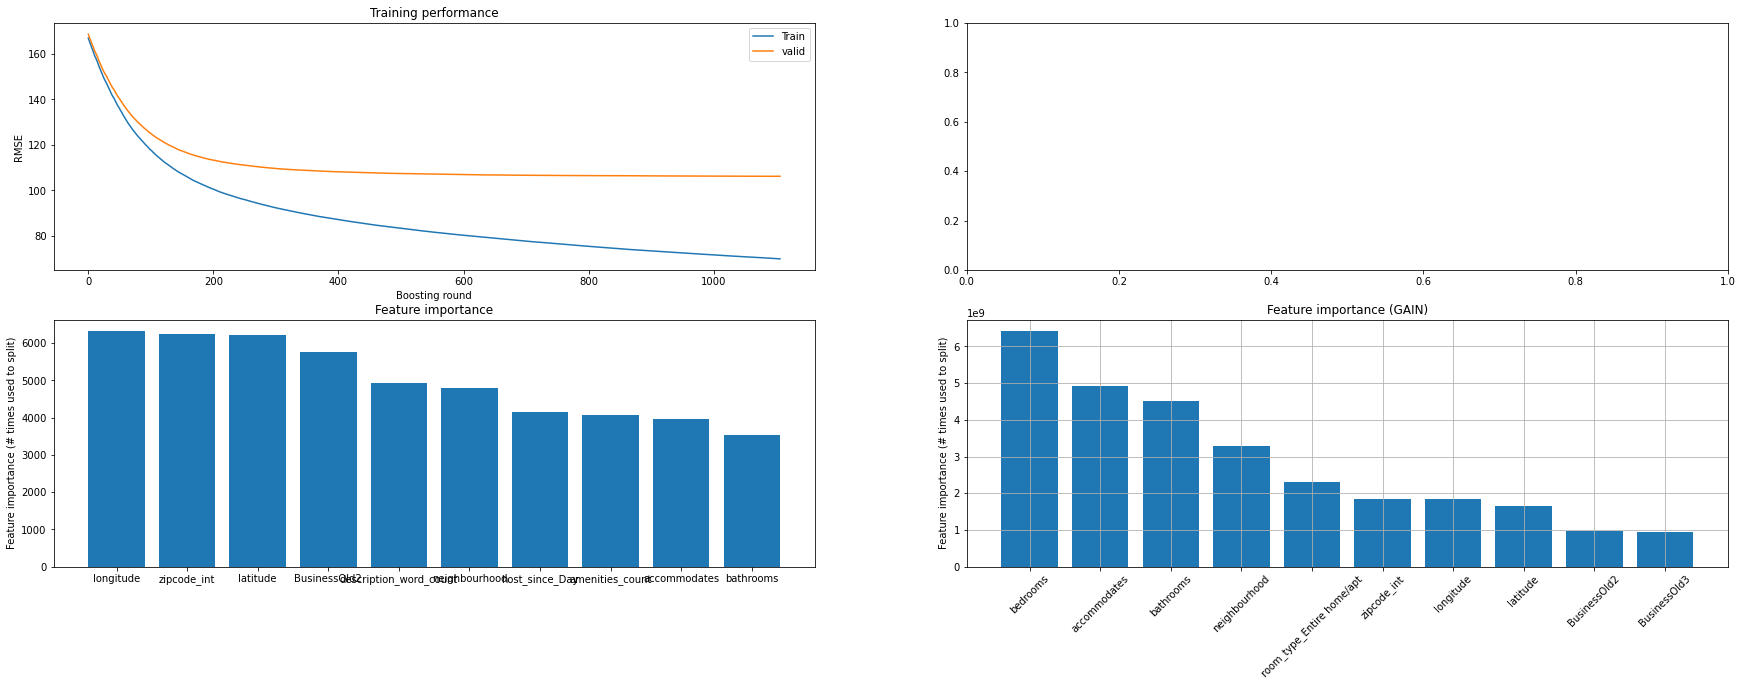

In [56]:
fig, axs = plt.subplots(2, 2, figsize=[30, 10])

# Plot the log loss during training
axs[0,0].plot(evaluation_results['train']['rmse'], label='Train')
axs[0,0].plot(evaluation_results['valid']['rmse'], label='valid')
axs[0,0].set_ylabel('RMSE')
axs[0,0].set_xlabel('Boosting round')
axs[0,0].set_title('Training performance')
axs[0,0].legend()

# Plot feature importance
importances = pd.DataFrame({'features': train_X.columns, 
                            'importance': model.feature_importance()}).sort_values('importance', ascending=False).head(10)
axs[1,0].bar(x=np.arange(len(importances)), height=importances['importance'])
axs[1,0].set_xticks(np.arange(len(importances)))
axs[1,0].set_xticklabels(importances['features'])
axs[1,0].set_ylabel('Feature importance (# times used to split)')
axs[1,0].set_title('Feature importance')
plt.xticks(rotation=45)

# Plot feature importance
importances = pd.DataFrame({'features': train_X.columns, 
                            'importance': model.feature_importance(importance_type='gain')}).sort_values('importance', ascending=False).head(10)
axs[1,1].bar(x=np.arange(len(importances)), height=importances['importance'])
axs[1,1].set_xticks(np.arange(len(importances)))
axs[1,1].set_xticklabels(importances['features'])
axs[1,1].set_ylabel('Feature importance (# times used to split)')
axs[1,1].set_title('Feature importance (GAIN)')

plt.xticks(rotation=45)
plt.grid(True)
plt.show()

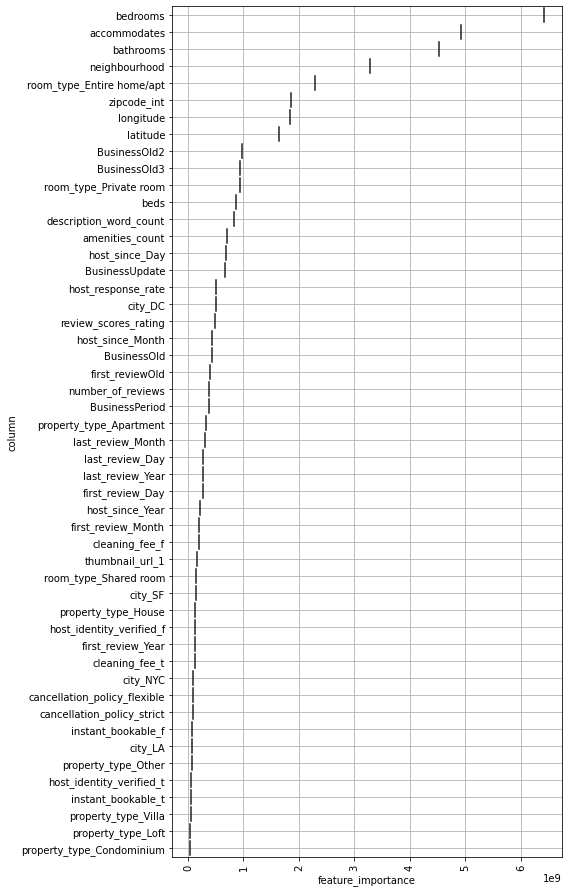

In [57]:
top_n=50
feature_importance_df = pd.DataFrame()

_df = pd.DataFrame()
_df['feature_importance'] = model.feature_importance(importance_type='gain')
_df['column'] = train_X.columns
feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

order = feature_importance_df.groupby('column').sum()[['feature_importance']].sort_values('feature_importance', ascending=False).index[:top_n]

fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
sns.boxenplot(data=feature_importance_df,
              x='feature_importance',
              y='column',
              order=order,
              ax=ax,
              palette='viridis',
              orient='h')
ax.tick_params(axis='x', rotation=90)
ax.tick_params(axis='x', rotation=90)
ax.grid()
fig.tight_layout()

## モデルの推論

In [60]:
y_pred = pd.Series(model.predict(valid_X.values,num_iteration=model.best_iteration))

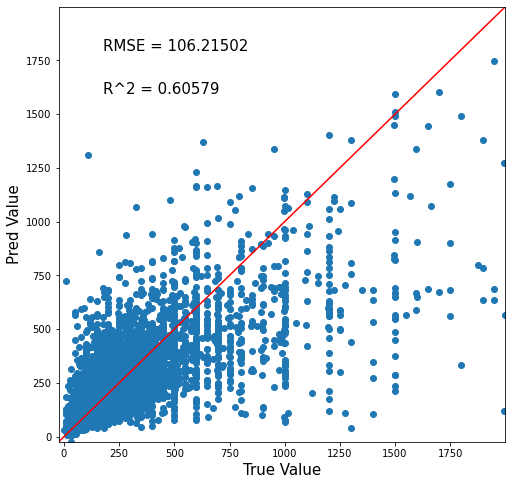

In [61]:
pred_df = pd.concat([valid_y.reset_index(drop=True), y_pred], axis=1)
pred_df.columns = ['true', 'pred']
# 可視化
True_Pred_map(pred_df)

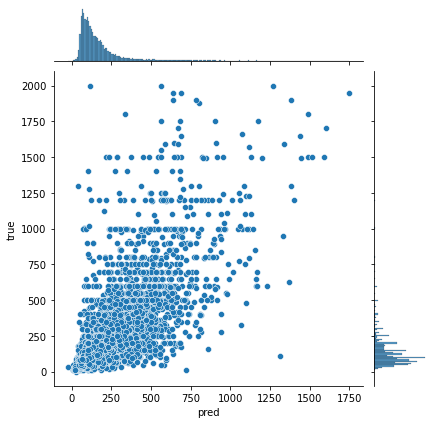

In [62]:
sns.jointplot(data=pred_df, x="pred", y="true")

In [ ]:
# with plt.style.context('fivethirtyeight'):
#     plt.figure(figsize=(10, 6))
#     plt.scatter(x=train_df['Time'], y= model.predict(train_X, num_iteration=model.best_iteration))
#     plt.title('Chicago Temperature')
#     plt.xlabel('Date')
#     plt.ylabel('Temperature, F')
#     plt.show()

## sharp値

In [71]:
#shap値を求める
shap.initjs()
# explainer = shap.TreeExplainer(model, data=train_X)
explainer = shap.TreeExplainer(model)

In [72]:
train_X_shap_values = explainer.shap_values(train_X)

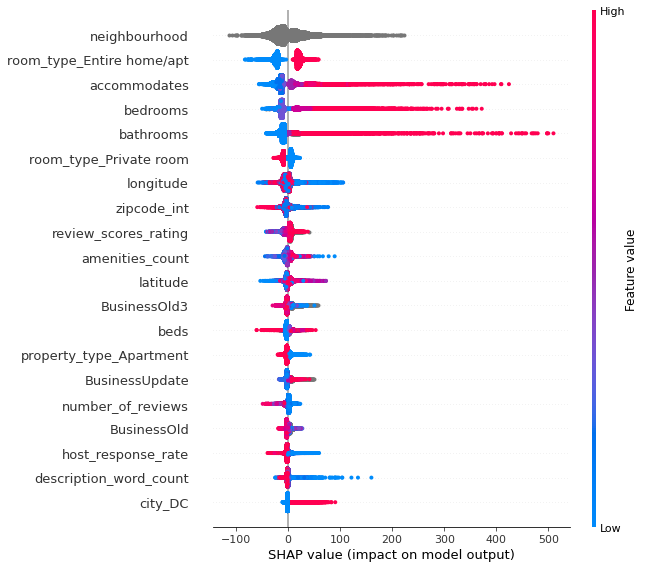

In [73]:
shap.summary_plot(shap_values=train_X_shap_values,
                  features=train_X,
                  feature_names=train_X.columns)

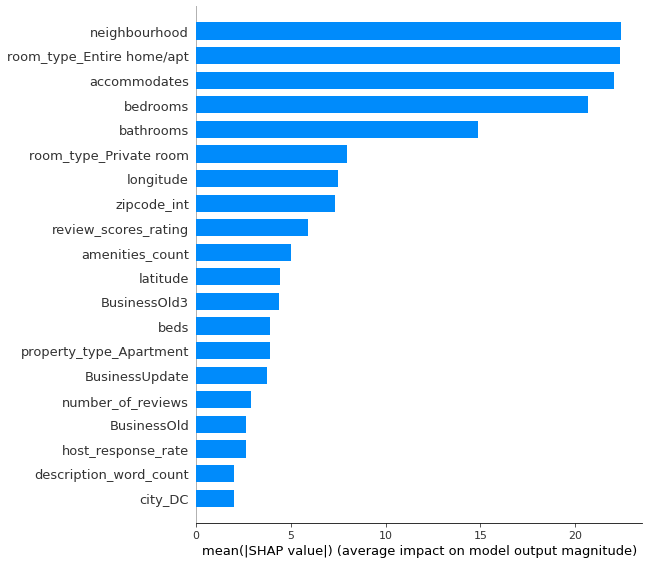

In [74]:
shap.summary_plot(shap_values=train_X_shap_values, features=train_X, plot_type="bar")

In [ ]:
shap.force_plot(base_value=explainer.expected_value, shap_values=train_X_shap_values, features=train_X)

# テストデータ

In [78]:
test_x.head()

accommodates                                          amenities  bathrooms  \
0             6  {TV,"Cable TV","Wireless Internet","Air condit...        2.0   
1             3  {TV,"Cable TV",Internet,"Wireless Internet","A...        1.0   
2             2  {TV,"Wireless Internet","Air conditioning",Kit...        1.0   
3             4  {TV,"Cable TV",Internet,"Wireless Internet","A...        1.0   
4             3  {TV,Internet,"Wireless Internet","Air conditio...        1.5   

   bed_type  bedrooms  beds cancellation_policy    city cleaning_fee  \
0  Real Bed       2.0   2.0              strict  Boston            t   
1  Real Bed       1.0   1.0            moderate      LA            t   
2  Real Bed       0.0   1.0            flexible     NYC            f   
3  Real Bed       1.0   2.0              strict     NYC            f   
4  Real Bed       1.0   2.0              strict      LA            t   

                                         description first_review  \
0  Feel free to book INSTANTLY. You can check-in ...   2017-01-09   
1  The guest house is close to: Equinox West Holl...   2016-08-17   
2  Private room in a three bedroom apartment in N...          NaN   
3  The apartment is located in historic Bed Stuy ...          NaN   
4  Our cozy, pet friendly one bedroom apartment/l...   2015-08-01   

  host_has_profile_pic host_identity_verified host_response_rate  host_since  \
0                    t                      f               100%  2016-08-23   
1                    t                      t               100%  2014-09-03   
2                    t                      t               100%  2012-10-17   
3                    t                      t                NaN  2013-01-23   
4                    t                      t               100%  2014-12-28   

  instant_bookable last_review   latitude   longitude  \
0                t  2017-09-25  42.359278  -71.069962   
1                f  2017-05-02  34.084747 -118.367355   
2                f         NaN  40.720541  -73.959192   
3                f         NaN  40.681117  -73.944091   
4                f  2016-09-11  34.150995 -118.409359   

                                                name       neighbourhood  \
0             Gorgeous 2BR/2BA Duplex in Beacon Hill         Beacon Hill   
1        Luxury 1 Bedroom West Hollywood City Center      West Hollywood   
2  Bedroom with Patio in Prime Williamsburg Locat...        Williamsburg   
3                         Cozy apartment in Brooklyn  Bedford-Stuyvesant   
4                 Cozy, sunny, pet friendly loft/apt                 NaN   

   number_of_reviews property_type  review_scores_rating        room_type  \
0                 58         House                  90.0  Entire home/apt   
1                  4    Guesthouse                 100.0  Entire home/apt   
2                  0     Apartment                   NaN     Private room   
3                  0     Apartment                   NaN  Entire home/apt   
4                  6          Loft                  92.0  Entire home/apt   

                                       thumbnail_url  zipcode  
0  https://a0.muscache.com/im/pictures/7e4808b4-5...    02114  
1  https://a0.muscache.com/im/pictures/5392fbd6-6...    90046  
2  https://a0.muscache.com/im/pictures/544d3b89-d...  11249.0  
3  https://a0.muscache.com/im/pictures/26baf7ba-0...    11216  
4  https://a0.muscache.com/im/pictures/86107545/9...    91604

## 前処理

In [64]:
df_ori_test = preprocessing(test_x)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## ダミー変数化

In [65]:
def fit_LabelEncoding(categorical_columns, training_df, Test_df):
    
    for column in tqdm(categorical_columns):
        df = Test_df.copy()
        le_column = LabelEncoder().fit(training_df[column].fillna('Na'))
        mask = df[column].isin(le_column.classes_)
        column_new_data = df[column].mask(mask).unique()
        le_column.classes_ = np.concatenate([le_column.classes_, column_new_data])
        df[column] = le_column.transform(df[column])

    return df

def fit_dummy(categorical_columns, training_df, Test_df):
    df = Test_df.copy()
    fit_dummy_columns = []
    for i in training_df.select_dtypes(include=object).columns.tolist():
        if i not in categorical_columns:
            fit_dummy_columns.append(i)
            
    for column in tqdm(training_df[fit_dummy_columns].columns):
        fit_type = training_df[column].dropna().unique()
        #NA = training_df[column].value_counts(dropna=False).index[0]
        df[column] = pd.Categorical(df[column], fit_type)
        
    df = pd.get_dummies(df, columns=fit_dummy_columns)
    return df

In [75]:
df_ori_test_dummy = fit_LabelEncoding(categorical_columns, df_train_addEDA, df_ori_test)
df_ori_test_dummy[categorical_columns] = df_ori_test_dummy[categorical_columns].astype('category')
#Today_results_all_S_dummy
df_ori_test_dummy = fit_dummy(categorical_columns, df_train_addEDA, df_ori_test_dummy)

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 98.19it/s]


In [77]:
df_ori_test.head()

accommodates  bathrooms  bed_type  bedrooms  beds cancellation_policy  \
0           6.0        2.0  Real Bed       2.0   2.0              strict   
1           3.0        1.0  Real Bed       1.0   1.0            moderate   
2           2.0        1.0  Real Bed       0.0   1.0            flexible   
3           4.0        1.0  Real Bed       1.0   2.0              strict   
4           3.0        1.5  Real Bed       1.0   2.0              strict   

     city cleaning_fee host_has_profile_pic host_identity_verified  \
0  Boston            t                    t                      f   
1      LA            t                    t                      t   
2     NYC            f                    t                      t   
3     NYC            f                    t                      t   
4      LA            t                    t                      t   

   host_response_rate instant_bookable   latitude   longitude  \
0               100.0                t  42.359278  -71.069962   
1               100.0                f  34.084747 -118.367355   
2               100.0                f  40.720541  -73.959192   
3                 0.0                f  40.681117  -73.944091   
4               100.0                f  34.150995 -118.409359   

        neighbourhood  number_of_reviews property_type  review_scores_rating  \
0         Beacon Hill               58.0         House                  90.0   
1      West Hollywood                4.0    Guesthouse                 100.0   
2        Williamsburg                0.0     Apartment                   NaN   
3  Bedford-Stuyvesant                0.0     Apartment                   NaN   
4                 NaN                6.0          Loft                  92.0   

         room_type thumbnail_url  amenities_count  description_word_count  \
0  Entire home/apt             1             21.0                  1000.0   
1  Entire home/apt             1             20.0                  1000.0   
2     Private room             1             10.0                  1000.0   
3  Entire home/apt             1             17.0                   220.0   
4  Entire home/apt             1             14.0                   898.0   

   first_review_Year  first_review_Month  first_review_Day  BusinessOld  \
0             2017.0                 1.0               9.0       2975.0   
1             2016.0                 8.0              17.0       2830.0   
2                NaN                 NaN               NaN          NaN   
3                NaN                 NaN               NaN          NaN   
4             2015.0                 8.0               1.0       2448.0   

   host_since_Year  host_since_Month  host_since_Day  BusinessOld2  \
0           2016.0               8.0            23.0        3095.0   
1           2014.0               9.0             3.0        2375.0   
2           2012.0              10.0            17.0        1689.0   
3           2013.0               1.0            23.0        1787.0   
4           2014.0              12.0            28.0        2491.0   

   first_reviewOld  last_review_Year  last_review_Month  last_review_Day  \
0            139.0            2017.0                9.0             25.0   
1            714.0            2017.0                5.0              2.0   
2              NaN               NaN                NaN              NaN   
3              NaN               NaN                NaN              NaN   
4            216.0            2016.0                9.0             11.0   

   BusinessOld3  BusinessUpdate  BusinessPeriod  zipcode_int  
0        3234.0          1557.0           259.0       2114.0  
1        3088.0          1703.0           258.0      90046.0  
2           NaN             NaN             NaN      11249.0  
3           NaN             NaN             NaN      11216.0  
4        2855.0          1936.0           407.0      91604.0

In [76]:
df_ori_test_dummy.head()

accommodates  bathrooms  bedrooms  beds  host_response_rate   latitude  \
0           6.0        2.0       2.0   2.0               100.0  42.359278   
1           3.0        1.0       1.0   1.0               100.0  34.084747   
2           2.0        1.0       0.0   1.0               100.0  40.720541   
3           4.0        1.0       1.0   2.0                 0.0  40.681117   
4           3.0        1.5       1.0   2.0               100.0  34.150995   

    longitude neighbourhood  number_of_reviews  review_scores_rating  \
0  -71.069962            40               58.0                  90.0   
1 -118.367355           573                4.0                 100.0   
2  -73.959192           595                0.0                   NaN   
3  -73.944091            42                0.0                   NaN   
4 -118.409359           608                6.0                  92.0   

   amenities_count  description_word_count  first_review_Year  \
0             21.0                  1000.0             2017.0   
1             20.0                  1000.0             2016.0   
2             10.0                  1000.0                NaN   
3             17.0                   220.0                NaN   
4             14.0                   898.0             2015.0   

   first_review_Month  first_review_Day  BusinessOld  host_since_Year  \
0                 1.0               9.0       2975.0           2016.0   
1                 8.0              17.0       2830.0           2014.0   
2                 NaN               NaN          NaN           2012.0   
3                 NaN               NaN          NaN           2013.0   
4                 8.0               1.0       2448.0           2014.0   

   host_since_Month  host_since_Day  BusinessOld2  first_reviewOld  \
0               8.0            23.0        3095.0            139.0   
1               9.0             3.0        2375.0            714.0   
2              10.0            17.0        1689.0              NaN   
3               1.0            23.0        1787.0              NaN   
4              12.0            28.0        2491.0            216.0   

   last_review_Year  last_review_Month  last_review_Day  BusinessOld3  \
0            2017.0                9.0             25.0        3234.0   
1            2017.0                5.0              2.0        3088.0   
2               NaN                NaN              NaN           NaN   
3               NaN                NaN              NaN           NaN   
4            2016.0                9.0             11.0        2855.0   

   BusinessUpdate  BusinessPeriod  zipcode_int  bed_type_Real Bed  \
0          1557.0           259.0       2114.0                  1   
1          1703.0           258.0      90046.0                  1   
2             NaN             NaN      11249.0                  1   
3             NaN             NaN      11216.0                  1   
4          1936.0           407.0      91604.0                  1   

   bed_type_Pull-out Sofa  bed_type_Airbed  bed_type_Futon  bed_type_Couch  \
0                       0                0               0               0   
1                       0                0               0               0   
2                       0                0               0               0   
3                       0                0               0               0   
4                       0                0               0               0   

   cancellation_policy_flexible  cancellation_policy_strict  \
0                             0                           1   
1                             0                           0   
2                             1                           0   
3                             0                           1   
4                             0                           1   

   cancellation_policy_moderate  cancellation_policy_super_strict_30  \
0                             0                                    0   
1         

In [84]:
sub_preds = pd.Series(model.predict(df_ori_test_dummy.values,num_iteration=model.best_iteration))

# Submit

In [95]:
#submit用のCSVを作成
sub = pd.DataFrame({"id":csv_to_df_test['id'], "y":sub_preds})
print('sub["y"].isnull().sum()=', sub['y'].isnull().sum())
sub

sub["y"].isnull().sum()= 0


id           y
0          0  202.701649
1          1  105.765529
2          2  167.255818
3          3  128.170058
4          4   82.897076
...      ...         ...
18523  18523  164.043055
18524  18524  103.441557
18525  18525  125.923529
18526  18526   90.656914
18527  18527   37.270441

[18528 rows x 2 columns]

In [93]:
# sub.to_csv("submission.csv", index=False)

In [96]:
sub.to_csv('fist_submission.csv', header=False, index=False)